In [1]:
__author__ = "Len Washington III"

import pandas as pd
import numpy as np
from seaborn import regplot
from matplotlib import pyplot as plt
from PIL import Image
from warnings import filterwarnings
from database import get_host_kwargs
from mysql.connector import connect
from python_scripts.project import *
filterwarnings("ignore")

In [ ]:
education_db = connect(**get_host_kwargs(database="sir"))
education_cursor = education_db.cursor(buffered=True)

police_brutality_db = connect(**get_host_kwargs(database="police_brutality"))
police_brutality_cursor = police_brutality_db.cursor(buffered=True)

### Education

In [2]:
def _biggest_race_generator(row:pd.core.series.Series) -> int:
	races = (row["Black Population"], row["Hispanic Population"], row["Native American Population"], row["Asian Population"], row["Pacific Islander Population"], row["White Population"], row["Other Population"])
	return Races.Races.value[races.index(max(races))]

def _second_biggest_race_generator(row:pd.core.series.Series) -> int:
	races = (row["Black Population"], row["Hispanic Population"], row["Native American Population"], row["Asian Population"], row["Pacific Islander Population"], row["White Population"], row["Other Population"])
	races = [i for i in races if i != max(races)]
	return Races.Races.value[races.index(max(races))]

def graduation_rate(file_name:str) -> pd.DataFrame:
	df = pd.read_csv(file_name)
	df["Biggest Race"] = df.apply(_biggest_race_generator, axis=1)
	df["Second Biggest Race"] = df.apply(_second_biggest_race_generator, axis=1)
	return df

races = ("Black", "Hispanic", "Native American", "Asian", "Pacific Islander", "White", "Other")
output_folder = "./outputs/gis"
figsize = (12,8)

all_state_data = graduation_rate(add_data_dir("Education/state_data_w_o_us.csv")).set_index("State")
# Enrollment sizes can be found in Education/elsec18_sumtables.csv, sheet_name=19

race_population_data = all_state_data.filter(["State", "Biggest Race", "Second Biggest Race"] + [f"{i} Population" for i in races])
state_education_data = all_state_data.filter(['State', 'State Abbreviation', 'Population 2018', 'Population 2020', 'Population 2021', 'Growth 2021', 'Census 2010', 'Growth Since 2010', 'Percent Of US', 'Density', 'Graduation Rate', 'Instruction Spending Per Pupil', 'Support Spending Per Pupil', 'Total Spending Per Pupil', 'Total Instruction Spending', 'Total Spending', 'Total Support Spending', 'Black Population', 'Hispanic Population', 'Native American Population', 'Asian Population', 'Pacific Islander Population', 'White Population', 'Other Population'])
graduation_spending_df = Spending(add_data_dir("Education/edu_spending.csv")).df.merge(Spending(add_data_dir("Education/21gradrates.csv")).df, how='left', left_index=True, right_index=True)

state_police_shooting_data = pd.read_excel(add_data_dir("Police/MPVDatasetDownload.xlsx"), sheet_name="2013-2020 Killings by State")
police_killings_department_data = pd.read_excel(add_data_dir("Police/MPVDatasetDownload.xlsx"), sheet_name="2013-2020 Killings by PD")
race_population_data.head()

,Biggest Race,Second Biggest Race,Black Population,Hispanic Population,Native American Population,Asian Population,Pacific Islander Population,White Population,Other Population
State,,,,,,,,,
Alabama,White,Black,1285737,203146,23243,63936,1521,3196730,90367
Alaska,White,Native American,22817,51186,103506,45617,8544,450754,56092
Arizona,White,Hispanic,286614,2163312,271946,222477,12523,3825886,163927
Arkansas,White,Black,458536,219052,17342,43441,7877,2173849,70574
California,Hispanic,Pacific Islander,2164519,15221577,138427,5525439,138911,14695836,1264051


##### There are only 4 states that aren't majority white, California, DC, Hawaii, New Mexico, which is why we'll be examining the second biggest race for plotting

In [ ]:
# race_population_data[race_population_data["Biggest Race"] != "White"].head()
education_cursor.execute("")
education_cursor.fetchall()

In [4]:
x = 0
def US_grad_rate(row):
	global x
	if row.name != "United States":
		x += row["High School Graduation Rate"]

graduation_spending_df.apply(US_grad_rate, axis=1)
graduation_spending_df["High School Graduation Rate"]["United States"] = round(x / 51, 1)

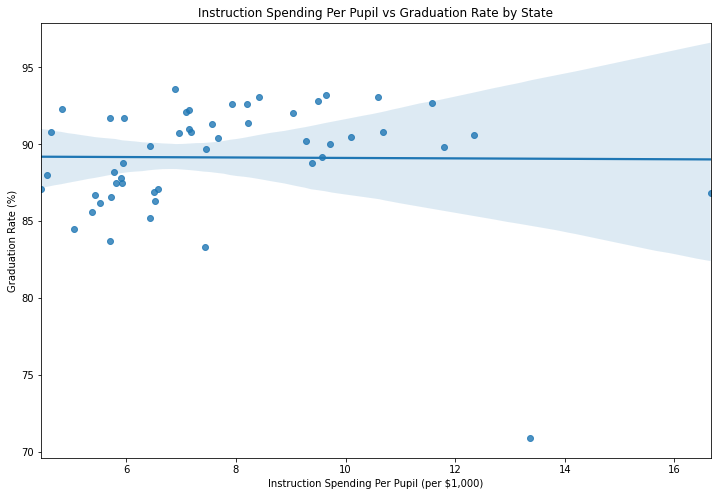

In [6]:
state_education_spending(state_education_data, "Instruction Spending Per Pupil", scale=1_000, save="instruction_spending_vs_grad_rate_original.png")

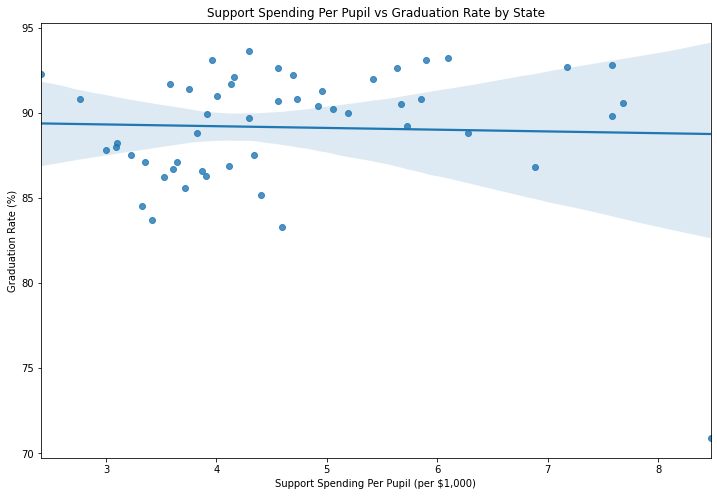

In [7]:
state_education_spending(state_education_data, "Support Spending Per Pupil", scale=1_000, save="support_spending_vs_grad_rate_original.png")

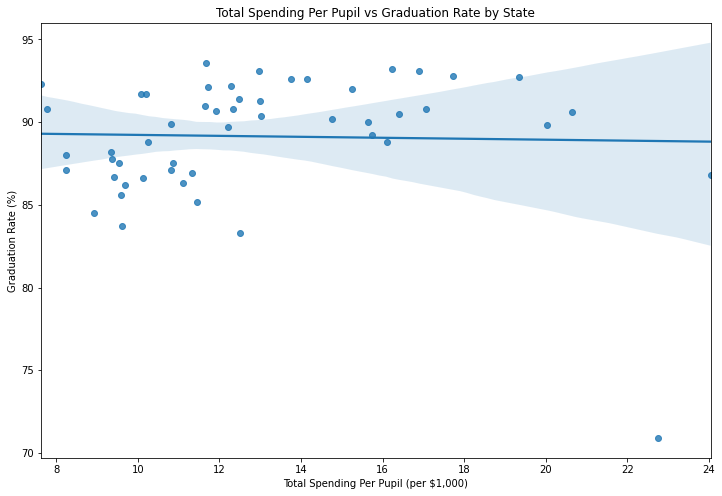

In [8]:
state_education_spending(state_education_data, "Total Spending Per Pupil", scale=1_000)

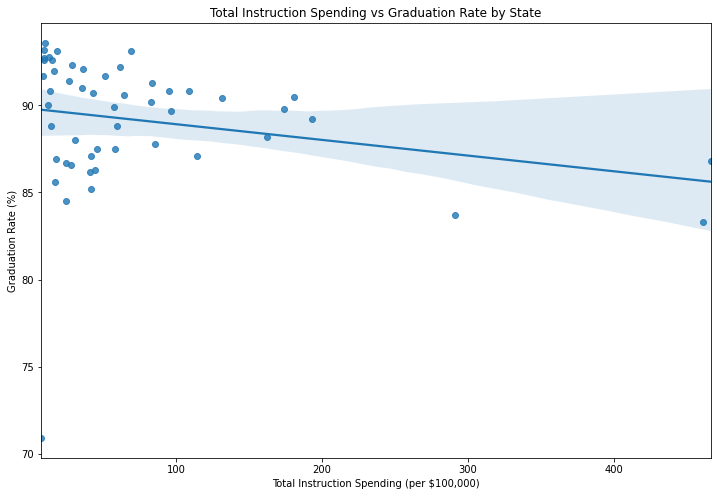

In [9]:
state_education_spending(state_education_data, "Total Instruction Spending", scale=100_000, save="total_instruction_spending_vs_grad_rate_original.png")

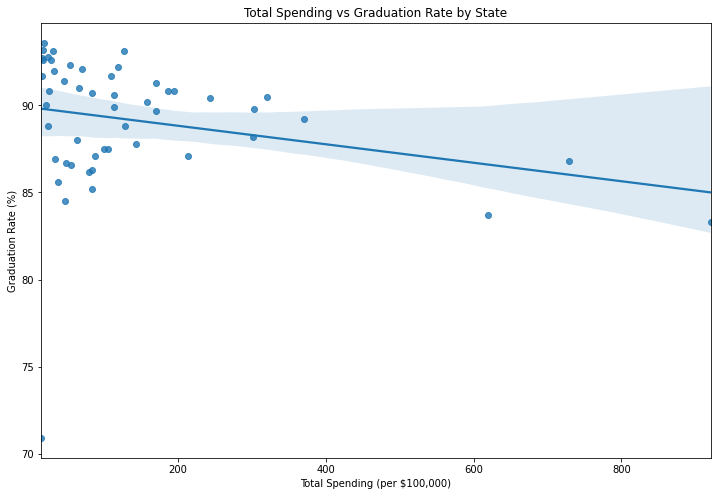

In [10]:
state_education_spending(state_education_data, "Total Spending", scale=100_000, save="total_spending_vs_grad_rate_original.png")

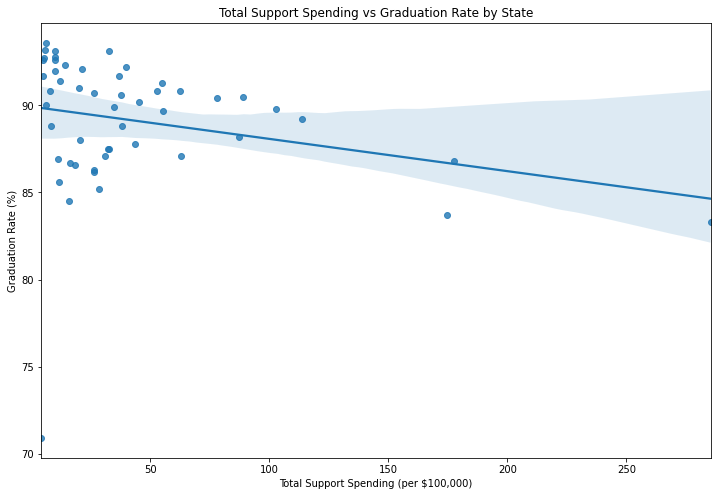

In [11]:
state_education_spending(state_education_data, "Total Support Spending", scale=100_000, save="total_support_spending_vs_grad_rate_original.png") #Graph graduation rate times population vs spending

#### Total Population vs Spending

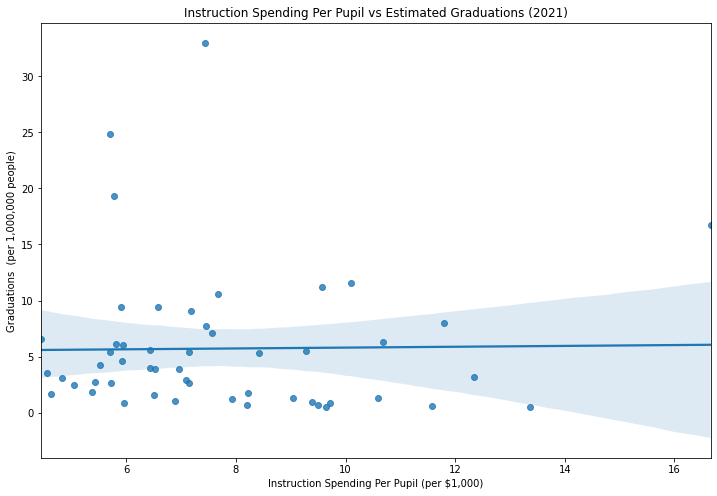

In [12]:
graph_total_population(state_education_data, "Instruction Spending Per Pupil" , x_scale=1_000)

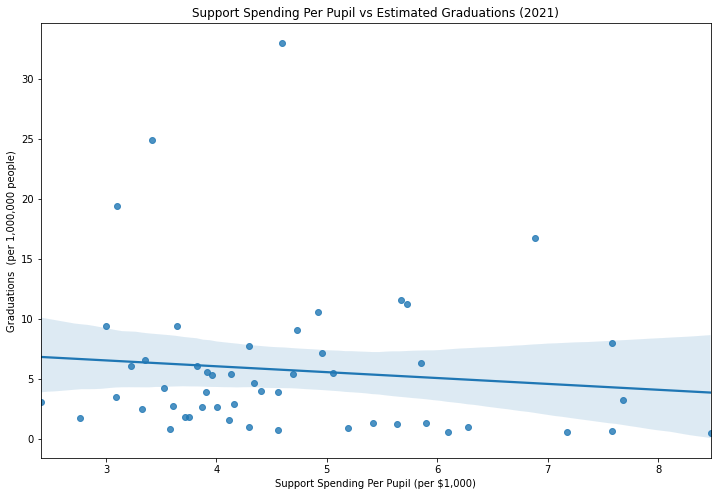

In [13]:
graph_total_population(state_education_data, "Support Spending Per Pupil", x_scale=1_000)

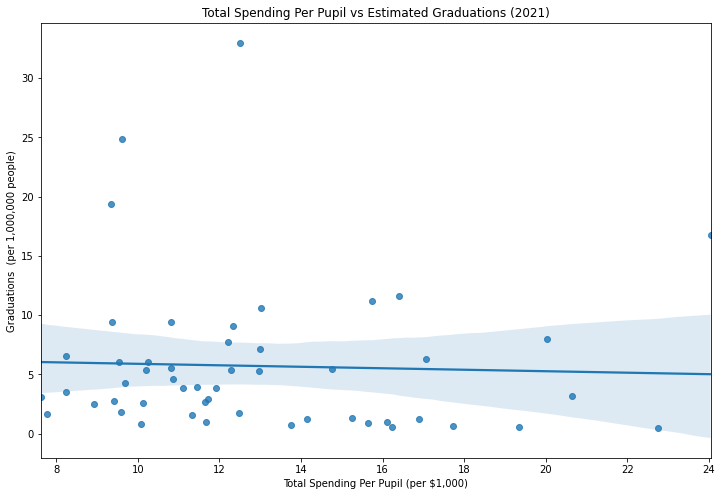

In [14]:
graph_total_population(state_education_data, "Total Spending Per Pupil", x_scale=1_000)

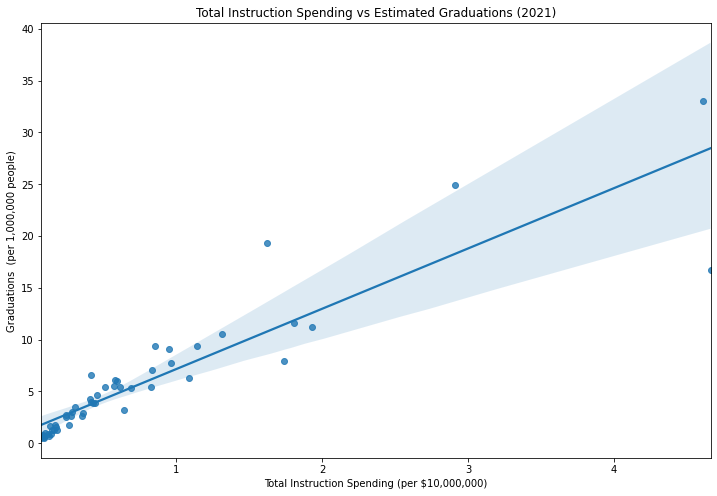

In [15]:
graph_total_population(state_education_data, "Total Instruction Spending", x_scale=10_000_000)

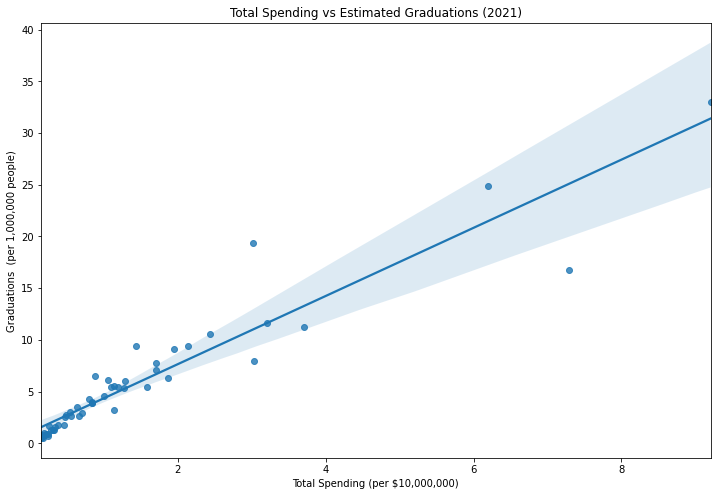

In [16]:
graph_total_population(state_education_data, "Total Spending", x_scale=10_000_000)

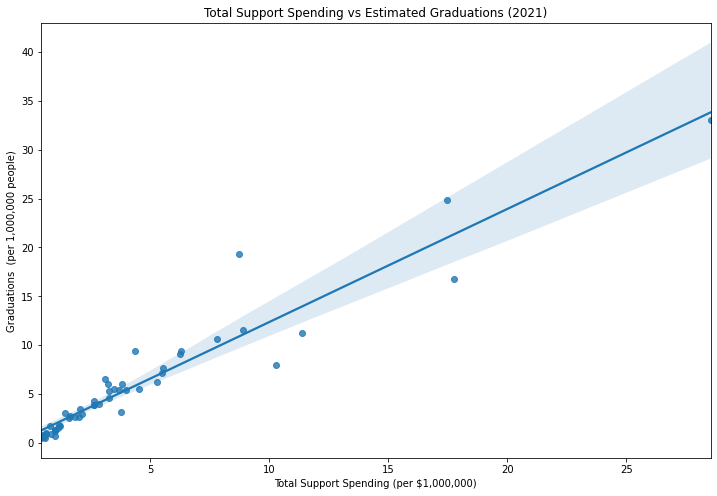

In [17]:
graph_total_population(state_education_data, "Total Support Spending", x_scale=1_000_000)

#### Spending vs Graduation Rates

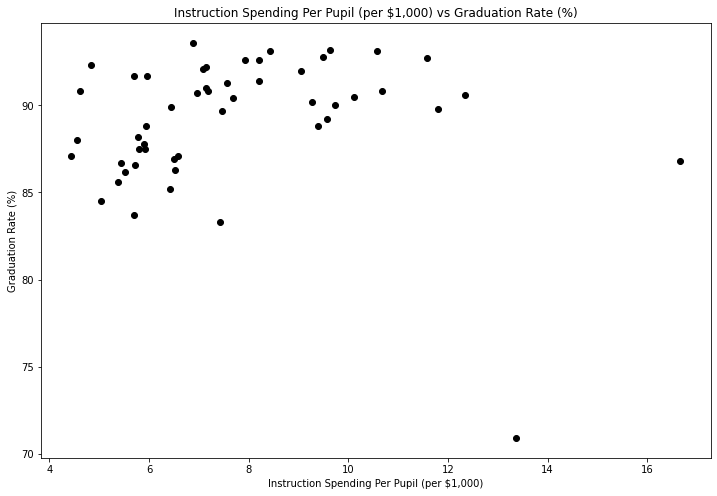

In [18]:
special="Illinois"
spending_graph(graduation_spending_df, "Instruction Spending Per Pupil", "High School Graduation Rate", x_scale=1000).show()

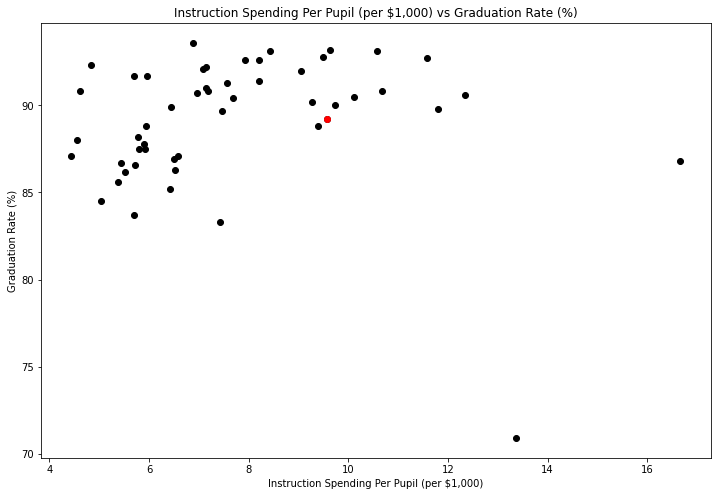

In [19]:
spending_graph(graduation_spending_df, "Instruction Spending Per Pupil", "High School Graduation Rate", special=special, x_scale=1000, save="instruction_spending_vs_grad_rate.png").show()

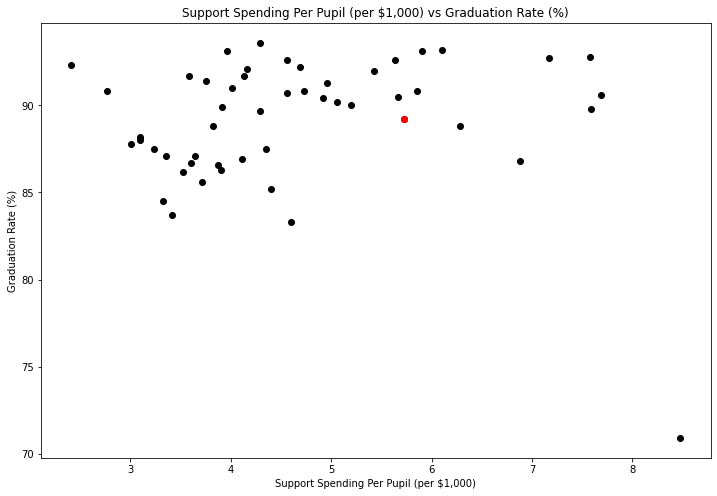

In [20]:
spending_graph(graduation_spending_df, "Support Spending Per Pupil", "High School Graduation Rate", special=special, x_scale=1000, save="support_spending_per_student_vs_grad_rate.png").show()

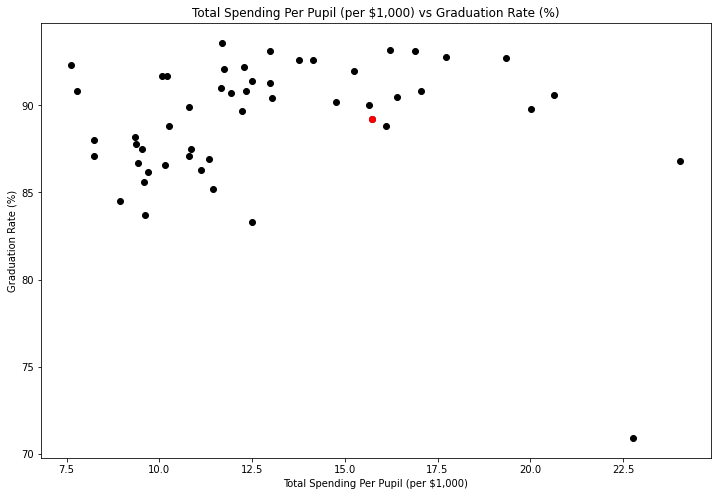

In [21]:
spending_graph(graduation_spending_df, "Total Spending Per Pupil", "High School Graduation Rate", special=special, x_scale=1000, save="total_spending_per_pupil_vs_grad_rate.png").show()

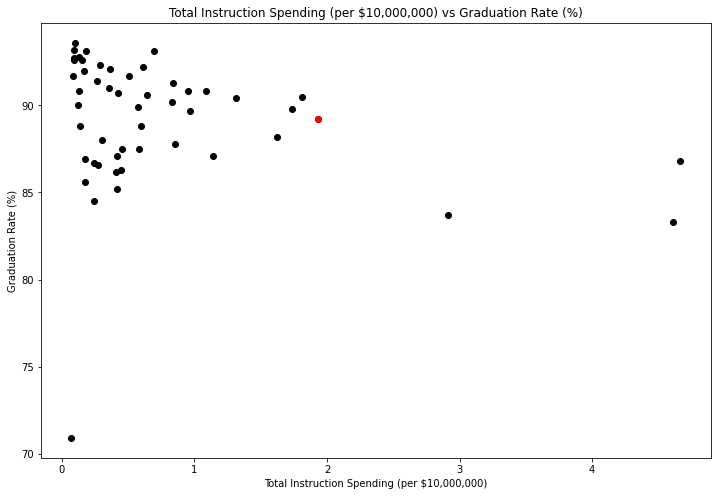

In [22]:
spending_graph(graduation_spending_df, "Total Instruction Spending", "High School Graduation Rate", special=special, x_scale=10_000_000, save="total_instruction_spending.png").show()

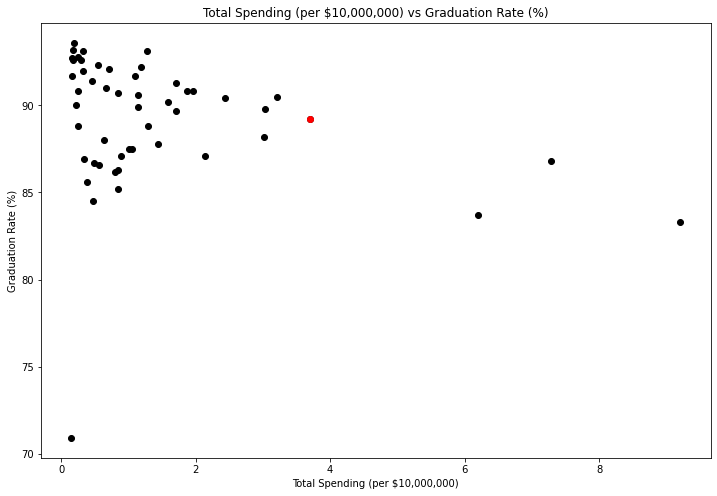

In [23]:
spending_graph(graduation_spending_df, "Total Spending", "High School Graduation Rate", special=special, x_scale=10_000_000, save="total_spending_vs_grad_rate.png").show()

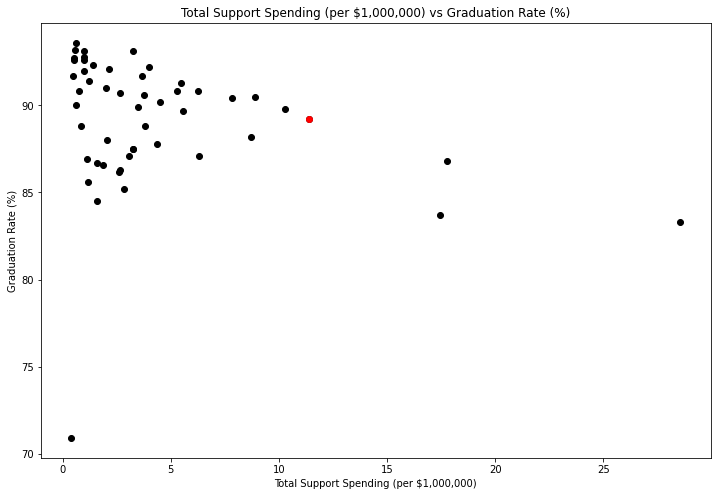

In [24]:
spending_graph(graduation_spending_df, "Total Support Spending", "High School Graduation Rate", special=special, x_scale=1_000_000, save="total_support_spending_vs_grad_rate.png").show()

#### Spending w/ Lines

<Figure size 864x576 with 0 Axes>

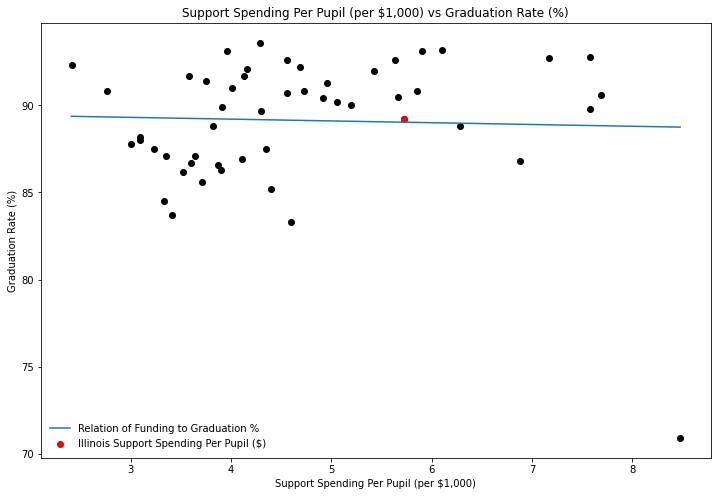

-0.00010222402608023601x + 89.6188357440409

In [26]:
spending_with_lines(graduation_spending_df, "Support Spending Per Pupil", "High School Graduation Rate", x_scale=1000, special=special, save="support_spending_per_student_vs_grad_rate_w_line.png")

<Figure size 864x576 with 0 Axes>

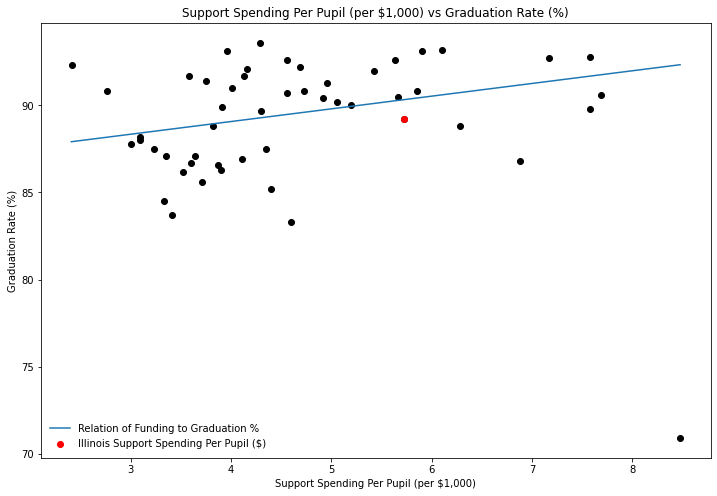

0.000728816760463765x + 86.15704226417232

In [27]:
spending_with_lines(graduation_spending_df, "Support Spending Per Pupil", "High School Graduation Rate", x_scale=1000, special=special, save="support_spending_per_student_vs_grad_rate_w_line_and_dc_removed.png", remove=["District of Columbia"])

<Figure size 864x576 with 0 Axes>

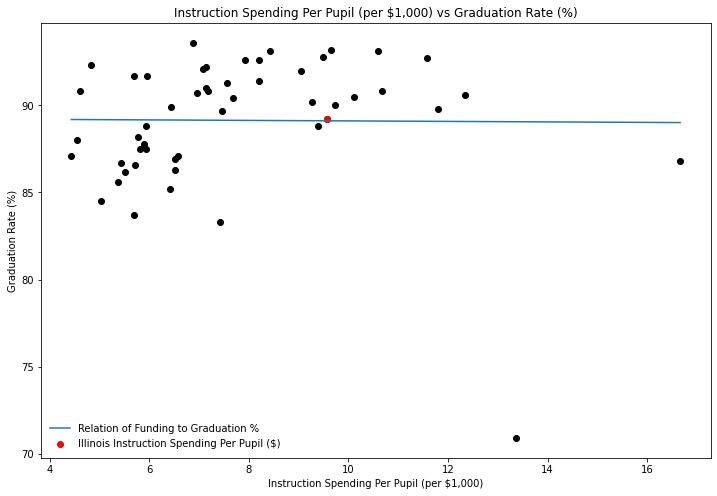

-1.43893622349908e-05x + 89.25323928987794

In [28]:
spending_with_lines(graduation_spending_df, "Instruction Spending Per Pupil", "High School Graduation Rate", x_scale=1000, special=special, save="instruction_spending_vs_grad_rate_w_line.png")

<Figure size 864x576 with 0 Axes>

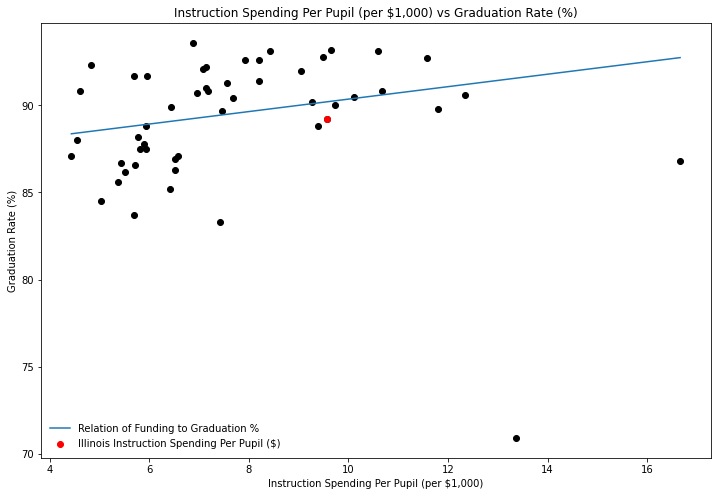

0.0003577358146435504x + 86.78178731735665

In [29]:
spending_with_lines(graduation_spending_df, "Instruction Spending Per Pupil", "High School Graduation Rate", x_scale=1000, special=special, save="instruction_spending_vs_grad_rate_w_line_w-o_DC.png", remove=["District of Columbia"])

<Figure size 864x576 with 0 Axes>

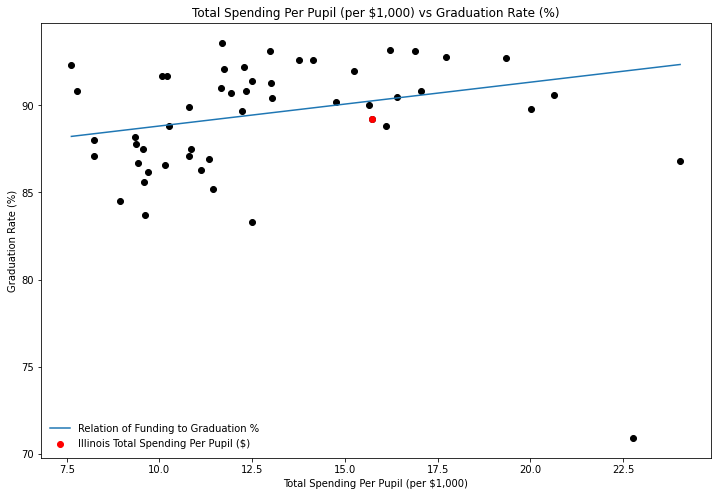

0.00025151900483898887x + 86.30130413111961

In [30]:
spending_with_lines(graduation_spending_df, "Total Spending Per Pupil", "High School Graduation Rate", x_scale=1000, special=special, save="total_spending_per_pupil_vs_grad_rate_w_line.png", remove=["District of Columbia"])

##### You can try running these 3 cells, but they gave me a MemoryError

<Figure size 864x576 with 0 Axes>

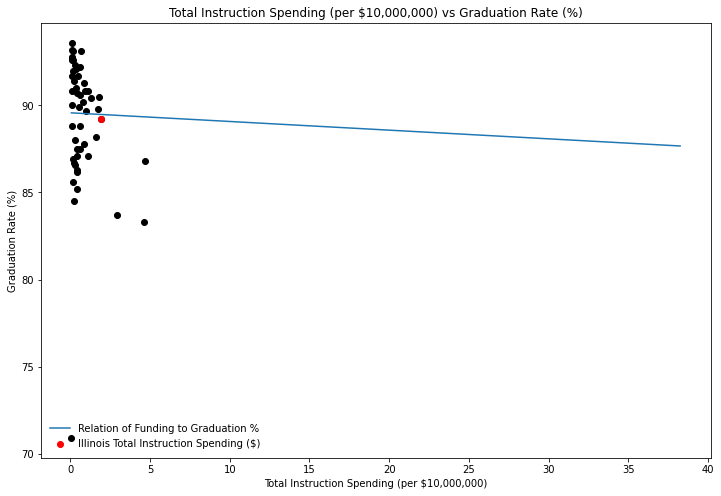

-4.9834821474609415e-09x + 89.57467933979568

In [31]:
spending_with_lines(graduation_spending_df, "Total Instruction Spending", "High School Graduation Rate", x_scale=10_000_000, special=special, save="total_instruction_spending_w_line.png", remove=["District of Columbia"])

<Figure size 864x576 with 0 Axes>

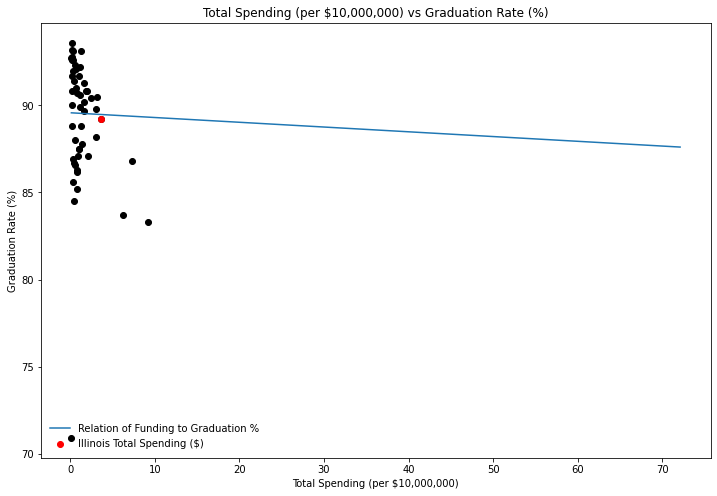

-2.7329087311255246e-09x + 89.57718496009457

In [32]:
spending_with_lines(graduation_spending_df, "Total Spending", "High School Graduation Rate", x_scale=10_000_000, special=special, save="total_spending_vs_grad_rate_w_line.png", remove=["District of Columbia"])

<Figure size 864x576 with 0 Axes>

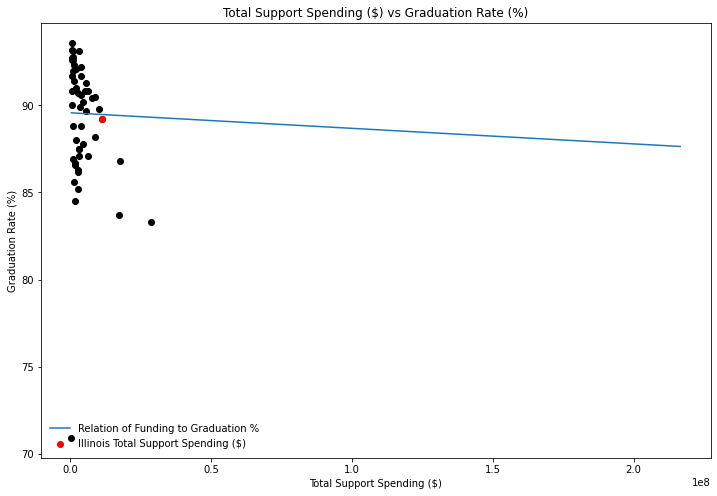

-8.93314269142157e-09x + 89.57578431339526

In [33]:
spending_with_lines(graduation_spending_df, "Total Support Spending", "High School Graduation Rate", special=special, save="total_support_spending_vs_grad_rate_w_line.png", remove=["District of Columbia"])

#### Spending Lines w/ Race

##### Big outlier is New York

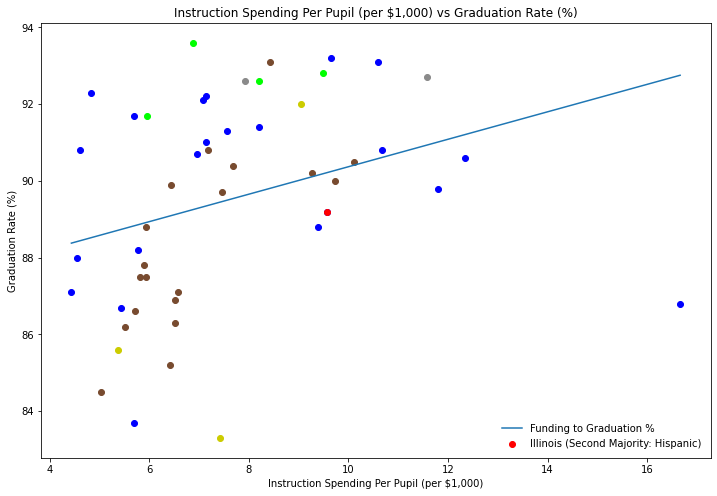

0.0003578133295107149x + 86.78956423236261

In [35]:
spending_with_lines_and_race(graduation_spending_df, "Instruction Spending Per Pupil", "High School Graduation Rate", x_scale=1000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States", "District of Columbia"], save="instruction_spending_vs_grad_rate_w_line_by_race.png")

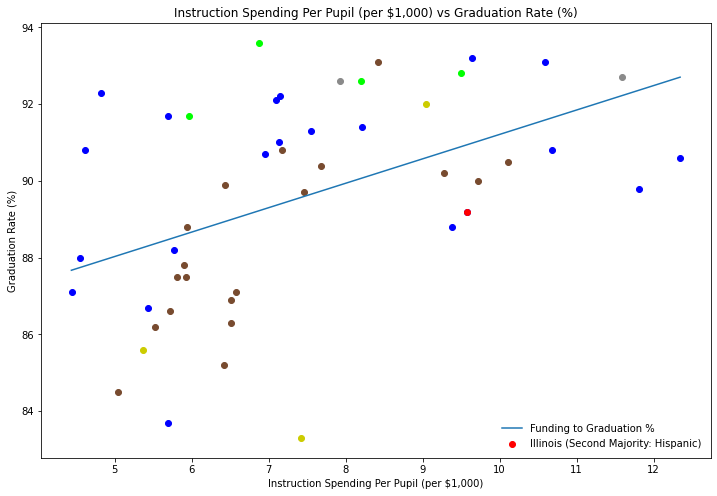

0.0006363742656492579x + 84.84621929051173

In [36]:
spending_with_lines_and_race(graduation_spending_df, "Instruction Spending Per Pupil", "High School Graduation Rate", x_scale=1000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States", "District of Columbia", "New York"], save="instruction_spending_vs_grad_rate_w_line_by_race_w-o_new_york.png")

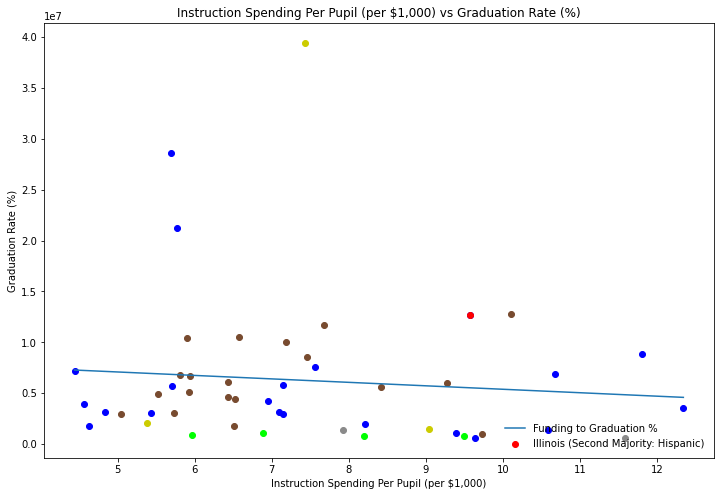

-339.9469392360849x + 8774009.897930566

In [37]:
spending_with_lines_and_race(all_state_data, "Instruction Spending Per Pupil", "Population 2018", x_scale=1000, color=race_population_data["Second Biggest Race"], special=special, remove=["District of Columbia", "New York"], save="instruction_spending_vs_grad_rate_w_line_by_race_w-o_new_york.png")

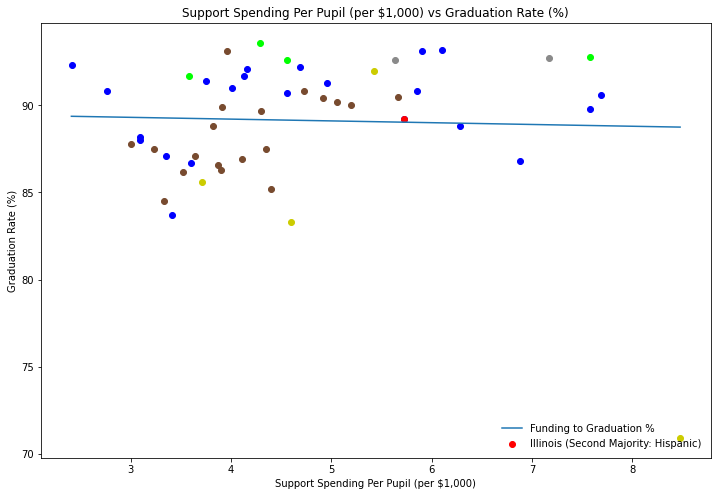

-0.00010235812863471575x + 89.62070097010194

In [38]:
spending_with_lines_and_race(graduation_spending_df, "Support Spending Per Pupil", "High School Graduation Rate", x_scale=1000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States"], save="support_spending_per_student_vs_grad_rate_w_line_by_race.png")

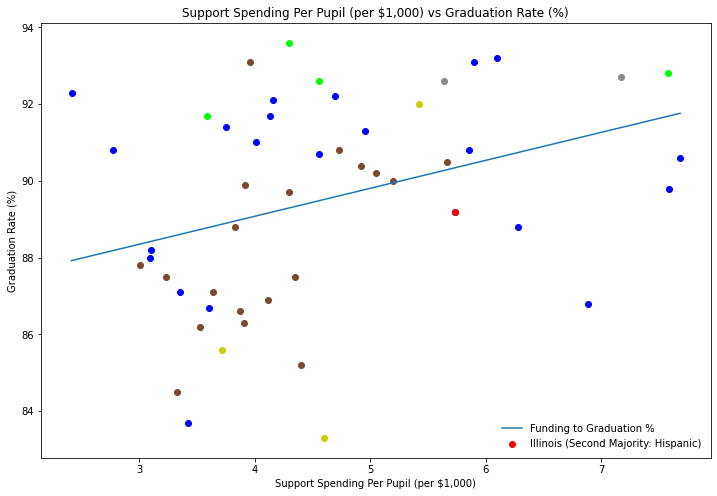

0.0007283326759723645x + 86.1653723533538

In [39]:
spending_with_lines_and_race(graduation_spending_df, "Support Spending Per Pupil", "High School Graduation Rate", x_scale=1000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States", "District of Columbia"], save="support_spending_per_student_vs_grad_rate_w_line_and_dc_removed_by_race.png")

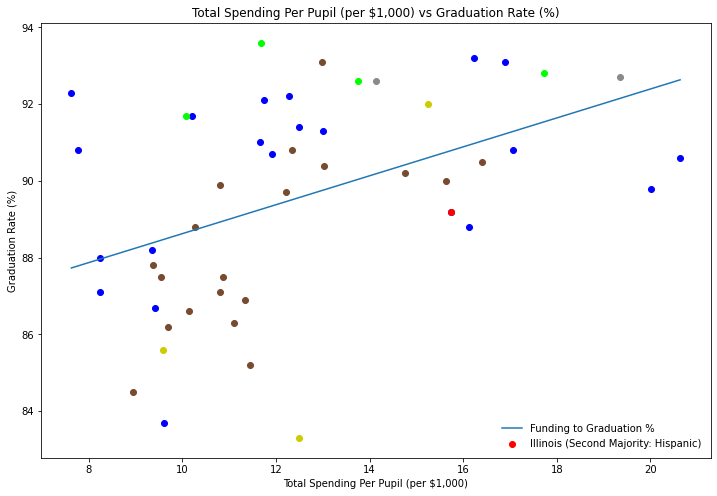

0.00037679001181364425x + 84.85768611120888

In [40]:
spending_with_lines_and_race(graduation_spending_df, "Total Spending Per Pupil", "High School Graduation Rate", x_scale=1000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States", "District of Columbia", "New York"], save="total_spending_per_pupil_vs_grad_rate_w_line_by_race.png")

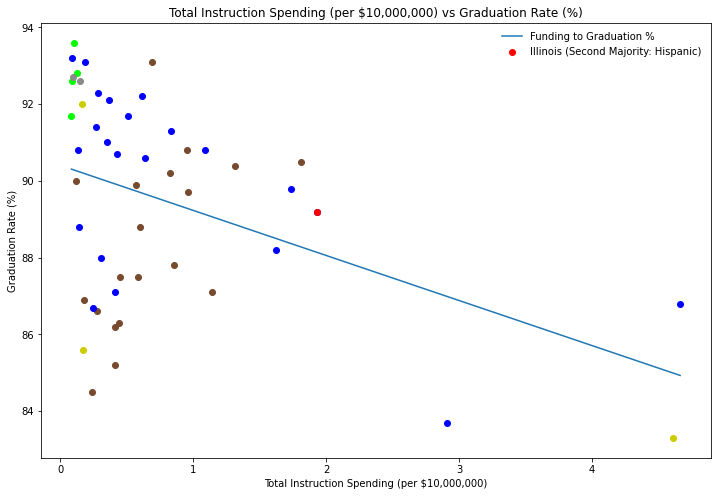

-1.1734170023494252e-07x + 90.4039505222728

In [41]:
spending_with_lines_and_race(graduation_spending_df, "Total Instruction Spending", "High School Graduation Rate", x_scale=10_000_000, color=race_population_data["Second Biggest Race"], save="total_instruction_spending_w_line_by_race.png", special=special, remove=["United States", "District of Columbia"], loc="upper right")

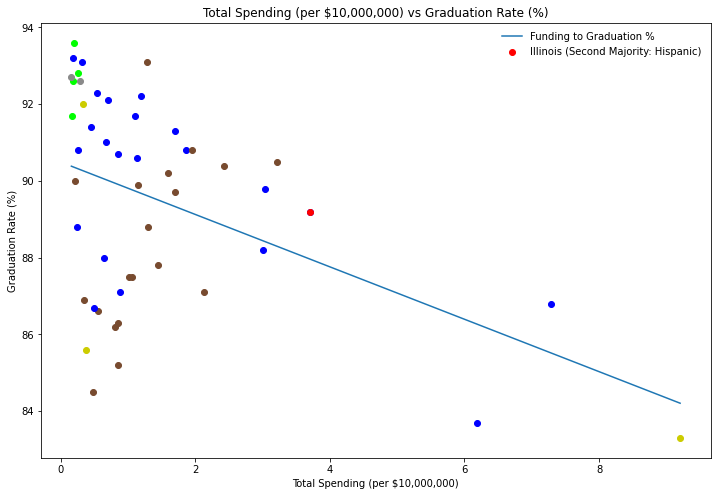

-6.825567321122808e-08x + 90.49011335241437

In [42]:
spending_with_lines_and_race(graduation_spending_df, "Total Spending", "High School Graduation Rate", x_scale=10_000_000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States", "District of Columbia"], loc="upper right", save="total_spending_vs_grad_rate_w_line_by_race.png")

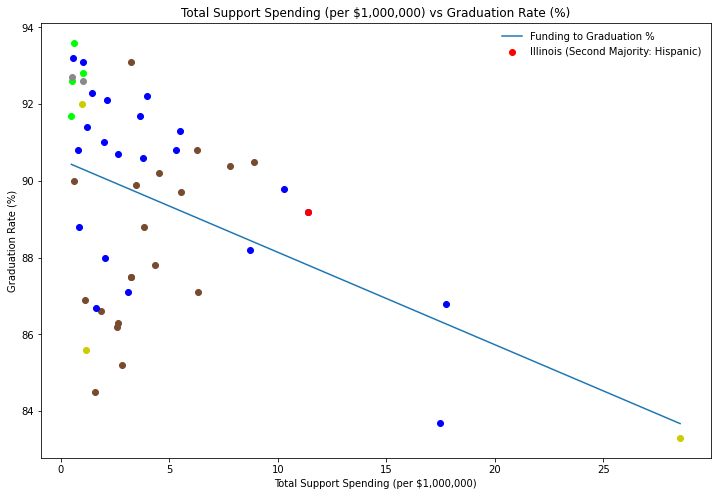

-2.408017281227087e-07x + 90.54886532051333

In [43]:
spending_with_lines_and_race(graduation_spending_df, "Total Support Spending", "High School Graduation Rate", x_scale=1_000_000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States", "District of Columbia"], save="total_support_spending_vs_grad_rate_w_line_by_race.png", loc="upper right")

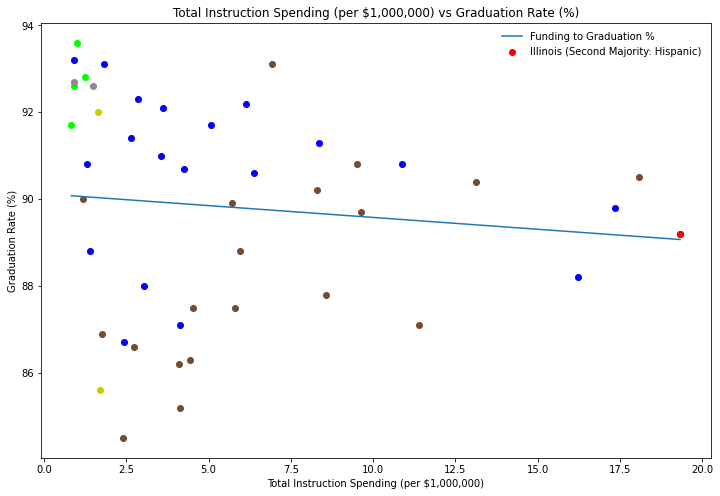

-5.44722228225818e-08x + 90.12248535764242

In [44]:
spending_with_lines_and_race(graduation_spending_df, "Total Instruction Spending", "High School Graduation Rate", x_scale=1_000_000, color=race_population_data["Second Biggest Race"], special=special, remove=["United States", "District of Columbia", "New York", "Texas", "California"], save="total_support_spending_vs_grad_rate_w_line_by_race.png", loc="upper right")

#### Graduation Rate per State by Race

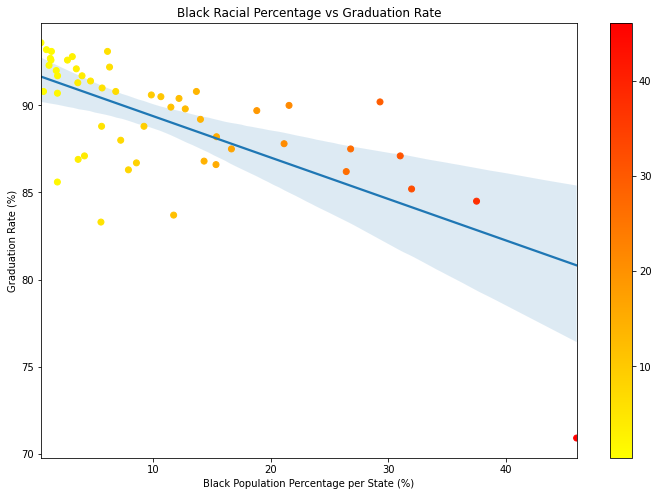

'-0.2374x + 91.7519'

In [45]:
racial_percentage_plot(state_education_data, "Black", save="black_percentage_vs_grad_rate.png")

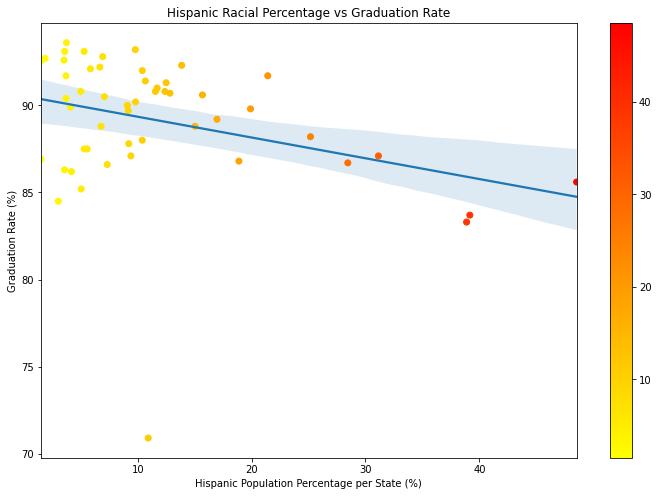

'-0.1193x + 90.5414'

In [46]:
racial_percentage_plot(state_education_data, "Hispanic", save="hispanic_percentage_vs_grad_rate.png")

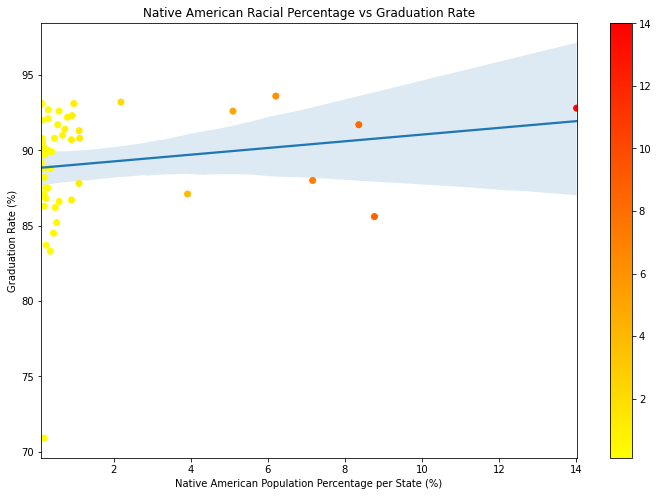

'0.2224x + 88.8203'

In [47]:
racial_percentage_plot(state_education_data, "Native American", save="native_american_percentage_vs_grad_rate.png")

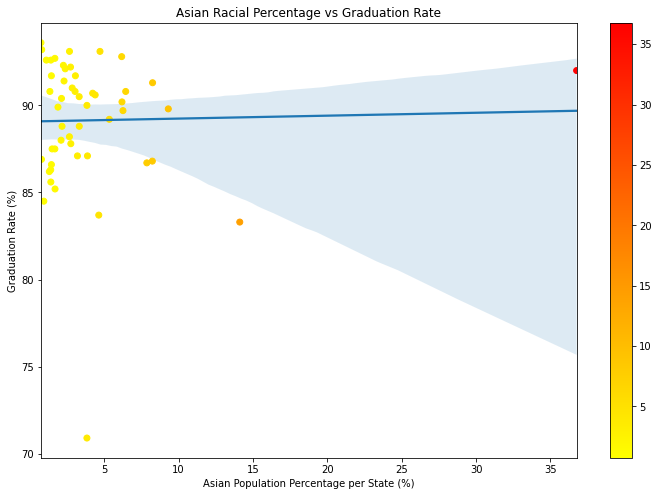

'0.0168x + 89.0741'

In [48]:
racial_percentage_plot(state_education_data, "Asian", save="asian_percentage_vs_grad_rate.png")

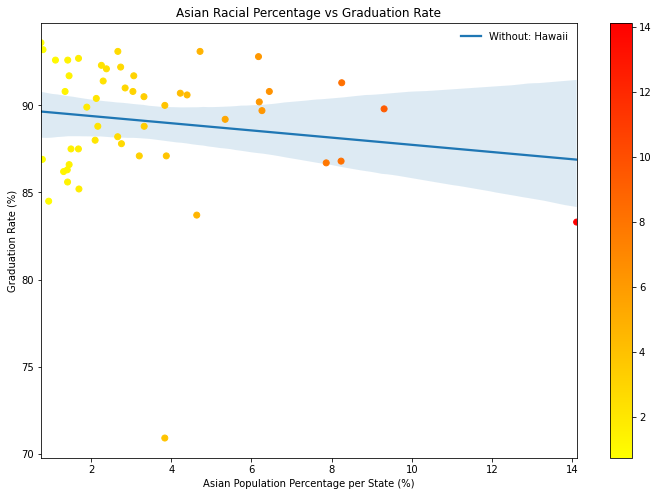

'-0.2066x + 89.8025'

In [49]:
racial_percentage_plot(state_education_data, "Asian", remove=["Hawaii"], save="asian_percentage_vs_grad_rate_w-o_hawaii.png")

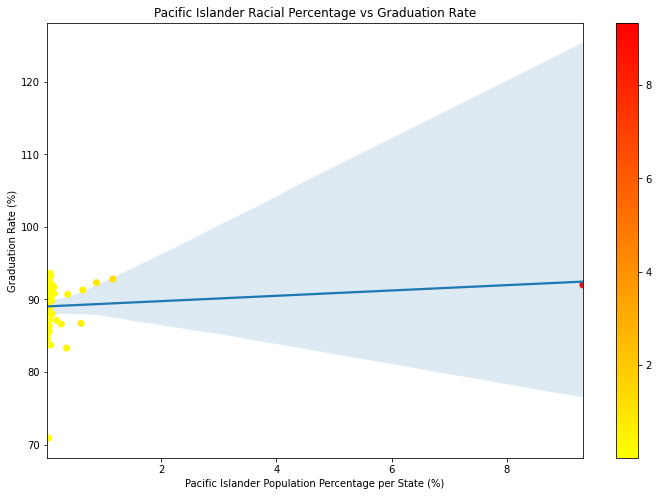

'0.3669x + 89.0295'

In [50]:
racial_percentage_plot(state_education_data, "Pacific Islander", save="pacific_islander_percentage_vs_grad_rate.png")

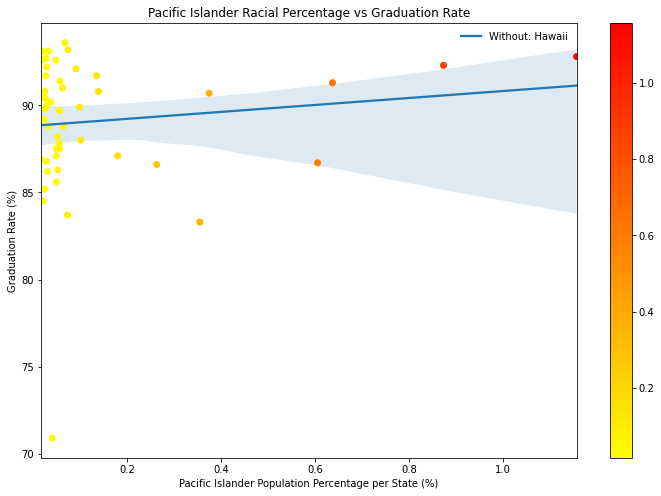

'1.9957x + 88.8277'

In [51]:
racial_percentage_plot(state_education_data, "Pacific Islander", remove=["Hawaii"], save="pacific_islander_percentage_vs_grad_rate_w-o_hawaii.png")

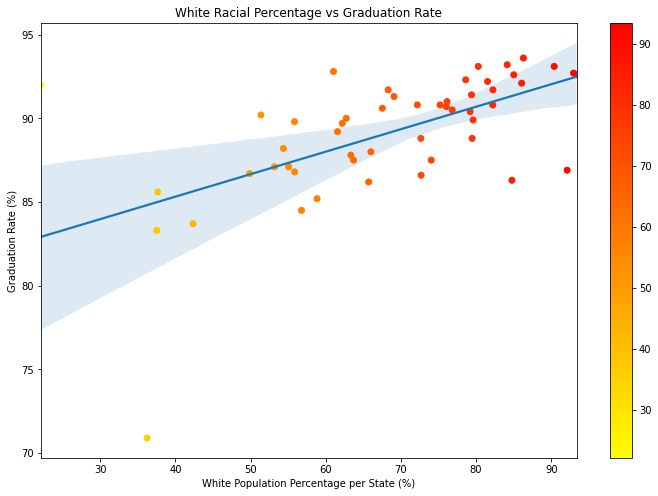

'0.1343x + 79.9456'

In [52]:
racial_percentage_plot(state_education_data, "White", save="white_percentage_vs_grad_rate.png")

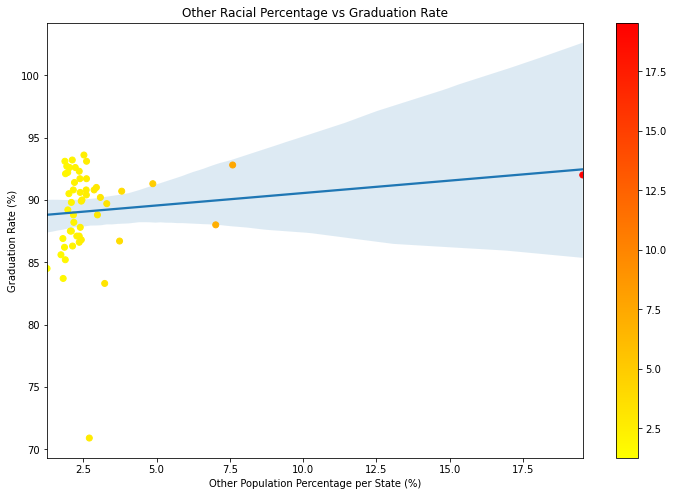

'0.1993x + 88.5572'

In [53]:
racial_percentage_plot(state_education_data, "Other", save="other_percentage_vs_grad_rate.png")

### Health

In [54]:
from causes import Causes
causes = Causes.from_csv(add_data_dir("Health/leading_causes_of_death.csv"))
causes.style.applymap(lambda x: 'white-space:wrap')
causes.head()

,Rank,Non-Blacks,All Blacks,Black Females,Black Males
0,Deaths,10109,9555,4593,4962
1,1,Heart disease 24.6%,Heart disease 23.9%,Heart disease 23.2%,Heart disease 24.4%
2,2,Cancer 22.2%,Cancer 20.9%,Cancer 22.4%,Cancer 19.5%
3,3,Accidents 6.0%,Accidents 6.7%,Stroke 7.7%,Homicide 9.3%
4,4,Stroke 5.9%,Stroke 6.1%,Accidents 4.0%,Accidents 9.2%


#### Life Expectancy

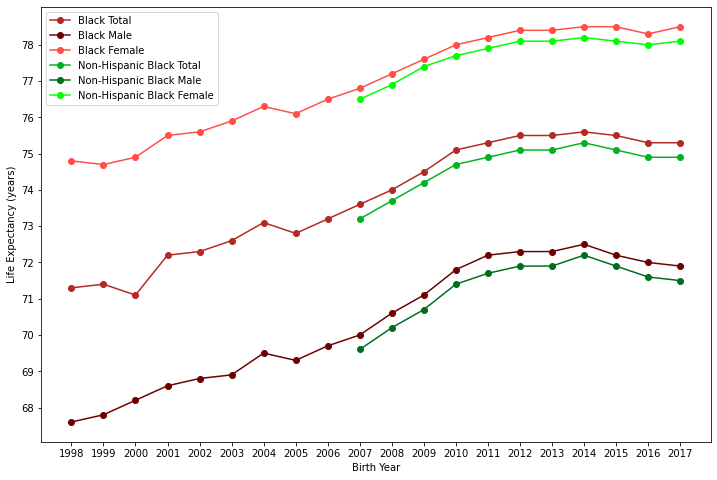

In [55]:
life_expectancy = LifeExpectancy(add_data_dir("Health/life_expectancy.csv"))
expectancy(life_expectancy, ["Black", "Non-Hispanic Black"], save="us_life_expectancy.png")

#### Mortality Rates

### Police

In [56]:
state_police_shooting_data.head() #Decided to search for my zipcode when I updated MPV xlsx on 3/3, and I was scared that it came up. 60653. I've been born and raised here, and I was scared that there was a shooting here. I looked at the address. It is less than 2 blocks from my house. I could leave out now and be there in 3 minutes.

,State,State Abbreviation,Total Population,Black Population,Hispanic Population,Native American Population,Asian Population,Pacific Islander Population,White Population,Other Population,...,Rate (White People),Rate (All People),Disparity in Rate,Black-White Disparity,Hispanic-White Disparity,Native American-White Disparity,Allegedly Armed People Killed by Police (1/1/2013-12/31/2020),Unarmed/Did Not Have an Actual Weapon People Killed by Police (1/1/2013-12/31/2020),Unclear Armed Status People Killed by Police (1/1/2013-12/31/2020),People Armed with Vehicle Killed by Police (1/1/2013-12/31/2020)
0,Alaska,AK,738516.0,22817.0,51186.0,103506.0,45617.0,8544.0,450754.0,56092.0,...,6.655515,8.293659,2.642198,3.292530,0.366925,2.177429,38.0,3.0,6.0,2.0
1,Alabama,AL,4864680.0,1285737.0,203146.0,23243.0,63936.0,1521.0,3196730.0,90367.0,...,3.284606,4.059876,1.412853,1.746331,0.187335,0.000000,104.0,23.0,19.0,12.0
2,Arkansas,AR,2990671.0,458536.0,219052.0,17342.0,43441.0,7877.0,2173849.0,70574.0,...,3.852613,4.890207,1.951090,2.476562,0.444353,0.000000,89.0,10.0,8.0,10.0
3,Arizona,AZ,6946685.0,286614.0,2163312.0,271946.0,222477.0,12523.0,3825886.0,163927.0,...,5.194875,7.053724,2.040366,2.770457,1.546075,1.327222,289.0,56.0,27.0,20.0
4,California,CA,39148760.0,2164519.0,15221577.0,138427.0,5525439.0,138911.0,14695836.0,1264051.0,...,3.130138,4.304095,2.737139,3.763702,1.416709,2.307893,889.0,233.0,144.0,82.0


In [62]:
for i in state_police_shooting_data:
	print(i)

State
State Abbreviation
Total Population
Black Population
Hispanic Population
Native American Population
Asian Population
Pacific Islander Population
White Population
Other Population
% African-American
% Victims Black
Disparity
# Black people killed
# Hispanic people killed
# Native American people killed
# Asian people killed
# Pacific Islanders killed
# White people killed
# Unknown Race people killed
# People Killed
Rate (Black People)
Rate (Hispanic People)
Rate (Native American People)
Rate (Asian People)
Rate (Pacific Islanders)
Rate (White People)
Rate (All People)
Disparity in Rate
Black-White Disparity
Hispanic-White Disparity
Native American-White Disparity
Allegedly Armed People Killed by Police (1/1/2013-12/31/2020)
Unarmed/Did Not Have an Actual Weapon People Killed by Police (1/1/2013-12/31/2020)
Unclear Armed Status People Killed by Police (1/1/2013-12/31/2020)
People Armed with Vehicle Killed by Police (1/1/2013-12/31/2020)


In [63]:
filter_list = ["Victim's name", "Victim's age", "Victim's gender", "Victim's race",
			   "Date of Incident", "Street Address of Incident", "City", "State", "Zipcode", "County",
			   "Agency responsible for death", "ORI Agency Identifier (if available)", "Cause of death", "Criminal Charges?",
			   "Symptoms of mental illness?", "Armed/Unarmed Status", "Fleeing (Source: WaPo)", "Body Camera (Source: WaPo)",
			   "Off-Duty Killing?", "Call for Service? (DRAFT)"]
filter_list

["Victim's name",
 "Victim's age",
 "Victim's gender",
 "Victim's race",
 'Date of Incident',
 'Street Address of Incident',
 'City',
 'State',
 'Zipcode',
 'County',
 'Agency responsible for death',
 'ORI Agency Identifier (if available)',
 'Cause of death',
 'Criminal Charges?',
 'Symptoms of mental illness?',
 'Armed/Unarmed Status',
 'Fleeing (Source: WaPo)',
 'Body Camera (Source: WaPo)',
 'Off-Duty Killing?',
 'Call for Service? (DRAFT)']

In [64]:
police_killings_2013_2020 = pd.read_excel(add_data_dir("Police/MPVDatasetDownload.xlsx"), sheet_name="2013-2021 Police Killings")

def map_to_boolean(df:pd.DataFrame, columns:list):
	for string in columns:
		df[string] = df[string].replace({"Yes": True, "No": False, "yes": True, "no": False})

def convert_to_int(df:pd.DataFrame, columns:list):
	for string in columns:
		df[string] = df[string].convert_dtypes(convert_integer=True)


police_killings_2013_2020 = police_killings_2013_2020.filter(filter_list, axis=1)
police_killings_2013_2020["Victim's race"] = police_killings_2013_2020["Victim's race"].replace(np.NaN, "Unknown Race")
convert_to_int(police_killings_2013_2020, ["Zipcode"])
map_to_boolean(police_killings_2013_2020, ["Call for Service? (DRAFT)", "Symptoms of mental illness?", "Body Camera (Source: WaPo)"])
police_killings_2013_2020.columns = ["Victim's name", "Victim's age", "Victim's gender", "Victim's race",
									 "Date of Incident", "Street Address of Incident", "City", "State", "Zipcode", "County",
									 "Agency Responsible for Death", "ORI Agency Identifier", "Cause of death", "Criminal Charges",
									 "Symptoms of mental illness", "Armed/Unarmed Status", "Fleeing", "Body Camera", "Off-Duty Killing", "Call for Service"]

police_killings_2013_2020.head()

,Victim's name,Victim's age,Victim's gender,Victim's race,Date of Incident,Street Address of Incident,City,State,Zipcode,County,Agency Responsible for Death,ORI Agency Identifier,Cause of death,Criminal Charges,Symptoms of mental illness,Armed/Unarmed Status,Fleeing,Body Camera,Off-Duty Killing,Call for Service
0,Lionel Womack,35,Male,Black,2021-11-22,North 57th Street and Interstate 70,Kansas City,KS,<NA>,Wyandotte,Kansas City Police Department,KS1050200,Gunshot,No known charges,Unknown,Allegedly Armed,Not Fleeing,True,False,True
1,Anthony Harden,30,Male,Black,2021-11-22,NaN,Fall River,MA,<NA>,Bristol,Fall River Police Department,MA0030800,Gunshot,No known charges,False,Unclear,Unknown,False,False,True
2,Name withheld by police,Unknown,Male,Unknown Race,2021-11-22,700 North Sunset Avenue,West Covina,CA,91790,Los Angeles,West Covina Police Department,CA0197500,Gunshot,No known charges,False,Allegedly Armed,Foot,False,False,False
3,Name withheld by police,Unknown,Male,Unknown Race,2021-11-22,3524 West Shore Road,Warwick,RI,2886,Kent,Warwick Police Department,RI0020300,Gunshot,No known charges,True,Allegedly Armed,Not Fleeing,False,False,True
4,Jabari Farafiai Asante-Chioke,52,Male,Black,2021-11-21,NaN,Metairie,LA,<NA>,Jefferson,"Louisiana State Police, East Jefferson Levee D...",LALSP0000,Gunshot,No known charges,False,Allegedly Armed,Foot,False,False,False


In [65]:
police_killings_2013_2020["Victim's race"].unique()

array(['Black', 'Unknown Race', 'White', 'Hispanic', 'Native American',
       'Asian', 'Pacific Islander'], dtype=object)

#### Percentage of Race vs Percentage of Shootings

In [66]:
race_percentages_in_america = {"Unknown Race": 6.2, "Hispanic": 16.3, "White": 72.4, "Black": 12.6, "Native American": .9, "Pacific Islander": .2, "Asian": 4.8} # https://www.cia.gov/the-world-factbook/countries/united-states/#people-and-society
police_killings_percentage = pd.DataFrame({"Race": [i for i in race_percentages_in_america.keys()]})
police_killings_percentage["Percentage of America"] = [i for i in race_percentages_in_america.values()]
police_killings_percentage["Percentage in Shootings"] = get_shooting_percentages(police_killings_2013_2020, race_percentages_in_america.keys())
police_killings_percentage["Ratio of Shootings in America"] = police_killings_percentage.apply(lambda row: row["Percentage in Shootings"] / row["Percentage of America"], axis=1)
police_killings_percentage.head(len(police_killings_percentage))

,Race,Percentage of America,Percentage in Shootings,Ratio of Shootings in America
0,Unknown Race,6.2,10.527398,1.697967
1,Hispanic,16.3,17.775265,1.090507
2,White,72.4,43.425517,0.599800
3,Black,12.6,24.827799,1.970460
4,Native American,0.9,1.408451,1.564945
5,Pacific Islander,0.2,0.575717,2.878585
6,Asian,4.8,1.459854,0.304136


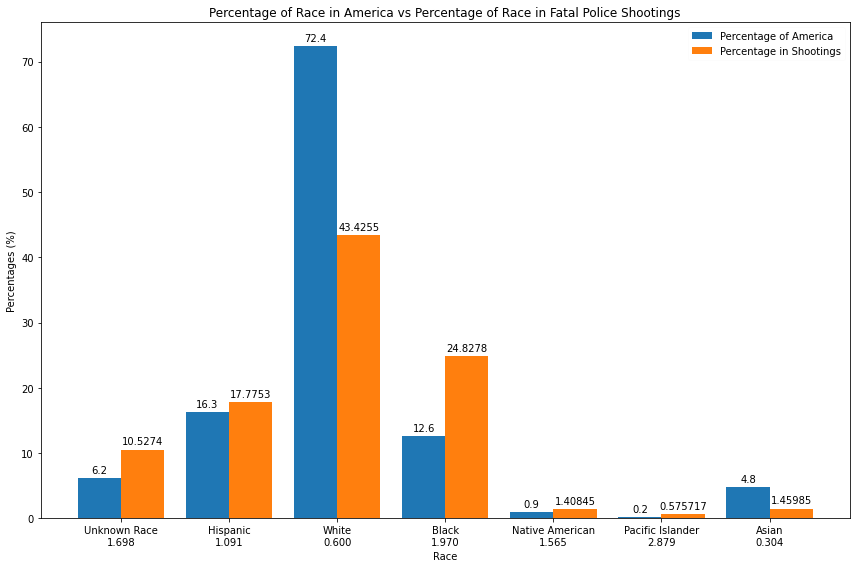

In [67]:
x = np.arange(len(race_percentages_in_america))
width = 0.4

fig, ax = plt.subplots(figsize=figsize)
population_rectangle = ax.bar(x - width/2, police_killings_percentage["Percentage of America"], width, label="Percentage of America")
shooting_rectangle = ax.bar(x + width/2, police_killings_percentage["Percentage in Shootings"], width, label="Percentage in Shootings")

ax.set_ylabel("Percentages (%)")
ax.set_xlabel("Race")
ax.set_title("Percentage of Race in America vs Percentage of Race in Fatal Police Shootings")
ax.set_xticks(x)
ax.set_xticklabels(get_x_ticks(police_killings_percentage))
ax.legend(fancybox=True, framealpha=0.05)

padding=3
ax.bar_label(population_rectangle, padding=padding)
ax.bar_label(shooting_rectangle, padding=padding)

fig.tight_layout()

plt.savefig(f"{output_folder}/police/police_shootings_percent_vs_population_percent.png", transparent=True)
plt.show()

#### Statistics and Pie Charts

In [68]:
police_killings_percentage.head(len(police_killings_percentage))

,Race,Percentage of America,Percentage in Shootings,Ratio of Shootings in America
0,Unknown Race,6.2,10.527398,1.697967
1,Hispanic,16.3,17.775265,1.090507
2,White,72.4,43.425517,0.599800
3,Black,12.6,24.827799,1.970460
4,Native American,0.9,1.408451,1.564945
5,Pacific Islander,0.2,0.575717,2.878585
6,Asian,4.8,1.459854,0.304136


In [69]:
police_killings_percentage.columns

Index(['Race', 'Percentage of America', 'Percentage in Shootings',
       'Ratio of Shootings in America'],
      dtype='object')

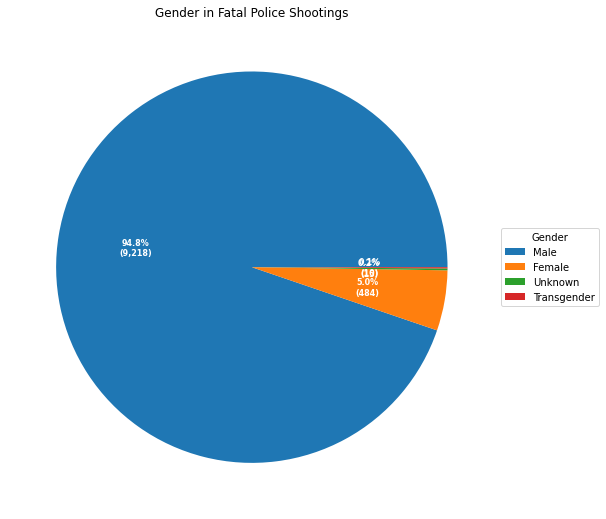

In [70]:
pie_chart(police_killings_2013_2020["Victim's gender"], "Gender", save="gender.png", cropping=True, warning=False)

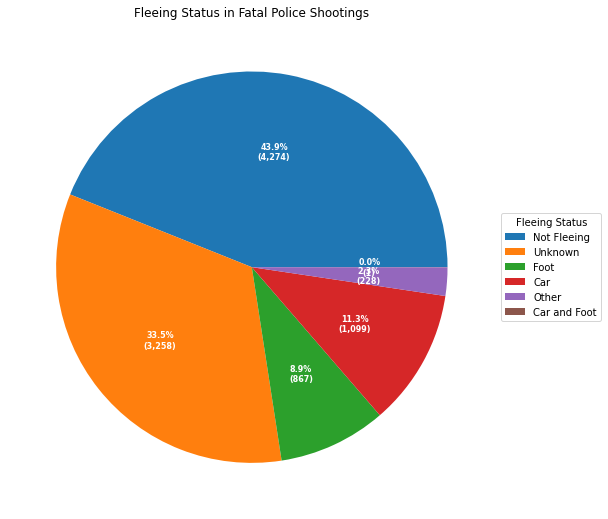

In [71]:
pie_chart(police_killings_2013_2020["Fleeing"], "Fleeing Status", save="fleeing.png", cropping=True)

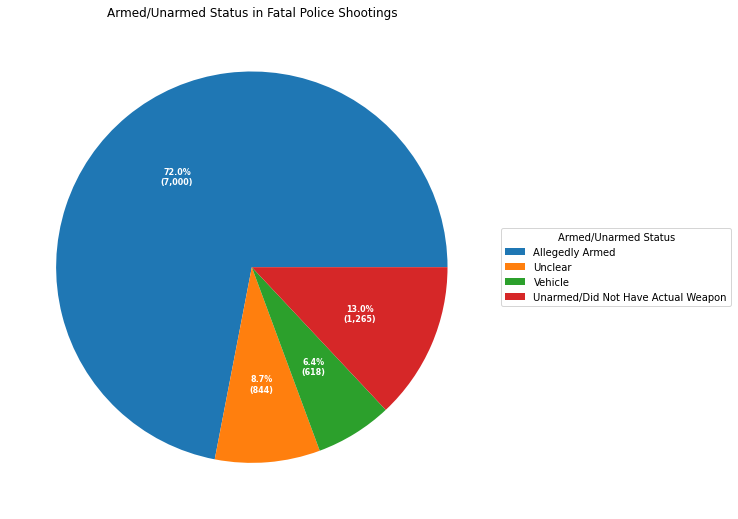

In [72]:
pie_chart(police_killings_2013_2020["Armed/Unarmed Status"], "Armed/Unarmed Status", save="armed.png", cropping=True)

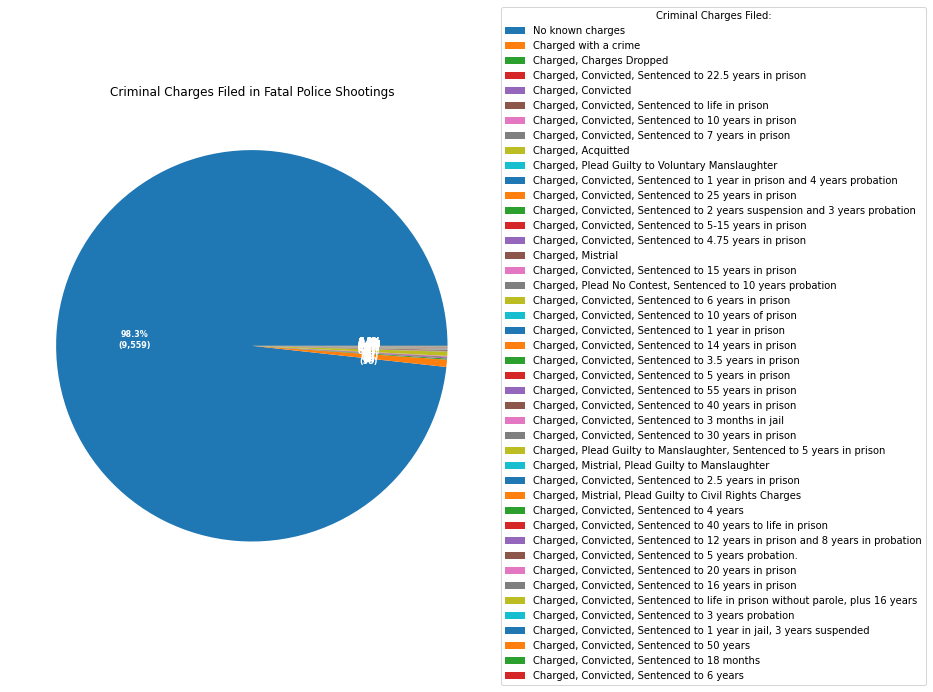

In [73]:
pie_chart(police_killings_2013_2020["Criminal Charges"], "Criminal Charges Filed:", save="charges.png", cropping=True)

In [74]:
#test = police_killings_2013_2020["Sentenced" in police_killings_2013_2020["Criminal Charges"]]
#test.head(len(test))

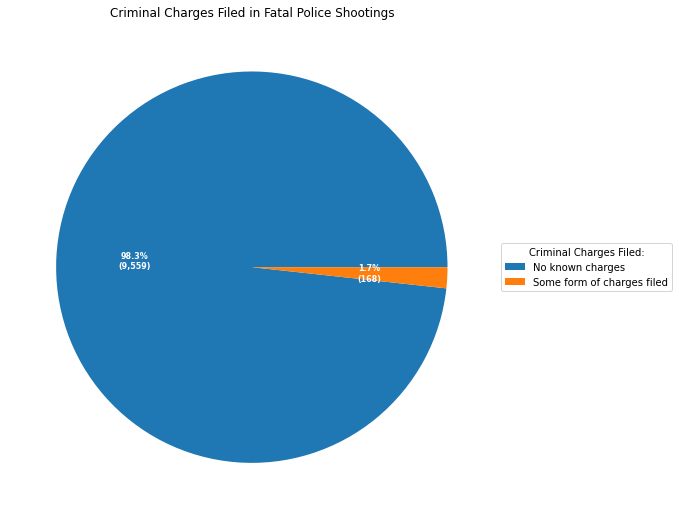

In [75]:
pie_chart(police_killings_2013_2020["Criminal Charges"], "Criminal Charges Filed:", save="charges_specified.png", cropping=True, focus=["No known charges"], other="Some form of charges filed")

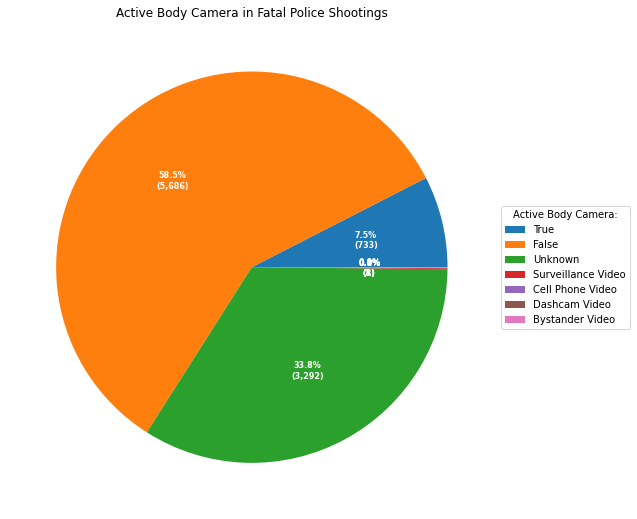

In [76]:
pie_chart(police_killings_2013_2020["Body Camera"], "Active Body Camera:", save="body_camera.png", cropping=True)

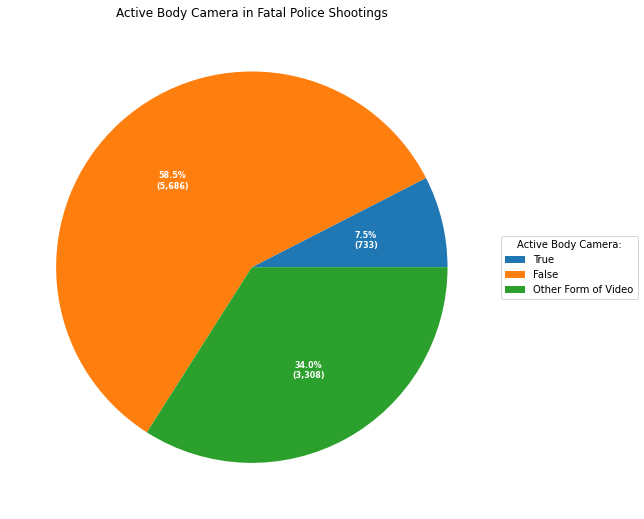

In [77]:
pie_chart(police_killings_2013_2020["Body Camera"], "Active Body Camera:", save="body_camera_specified.png", cropping=True, focus=[True, False], other="Other Form of Video")

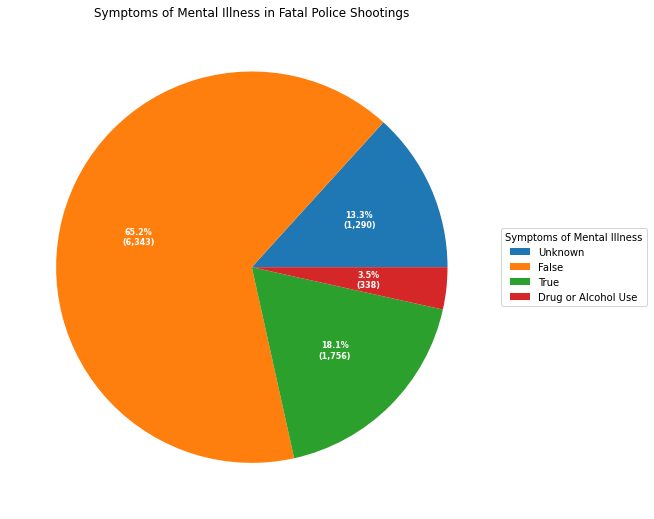

In [78]:
pie_chart(police_killings_2013_2020["Symptoms of mental illness"], "Symptoms of Mental Illness", save="mental_illness.png", cropping=True)

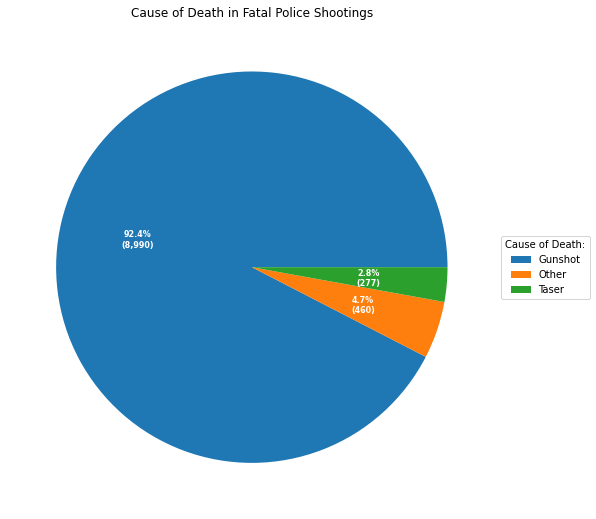

In [79]:
pie_chart(police_killings_2013_2020["Cause of death"], "Cause of Death:", save="cause_of_death.png", cropping=True, focus=["Gunshot", "Taser"])

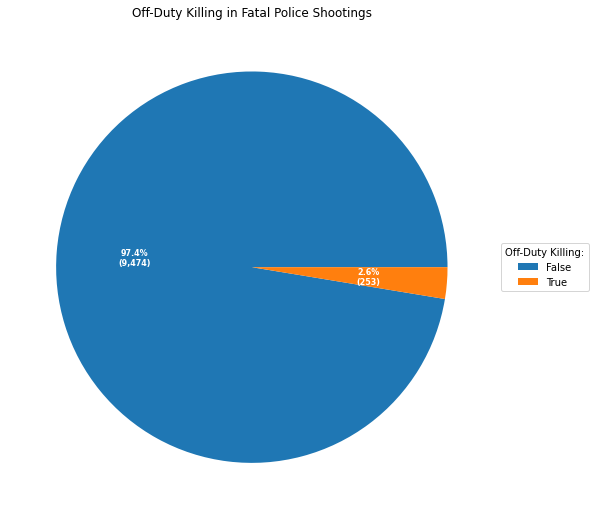

In [80]:
pie_chart(police_killings_2013_2020["Off-Duty Killing"], "Off-Duty Killing:", save="off_duty_killing.png", cropping=True)

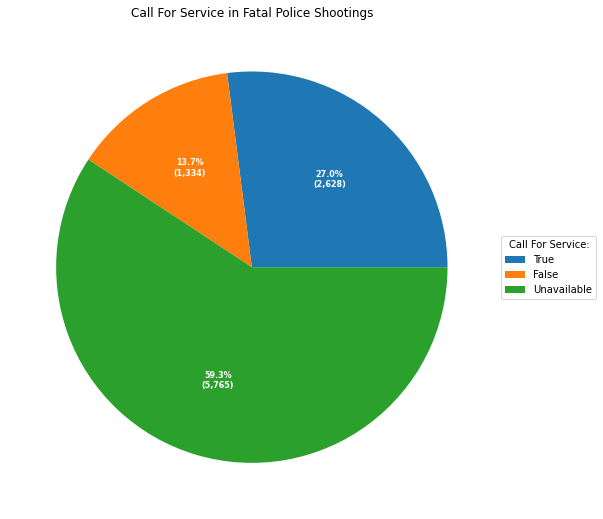

In [81]:
pie_chart(police_killings_2013_2020["Call for Service"], "Call For Service:", save="call_for_service.png", cropping=True)

In [82]:
#pie_chart(police_killings_2013_2020["Cause of death"], "Cause of Death:", save="cause_of_death.png", cropping=True, split_on_comma=True)

#### Convictions vs Race

In [83]:
charged = police_killings_2013_2020["No known charges" != police_killings_2013_2020["Criminal Charges"]]
char
charged.head()

,Victim's name,Victim's age,Victim's gender,Victim's race,Date of Incident,Street Address of Incident,City,State,Zipcode,County,Agency Responsible for Death,ORI Agency Identifier,Cause of death,Criminal Charges,Symptoms of mental illness,Armed/Unarmed Status,Fleeing,Body Camera,Off-Duty Killing,Call for Service
82,Jamie Liang,24,Female,Asian,2021-10-13,NaN,New York,NY,<NA>,Kings,New York Police Department,NY0303000,Gunshot,Charged with a crime,False,Unarmed/Did Not Have Actual Weapon,Not Fleeing,False,True,False
132,Manuela Rodriguez,18,Female,Hispanic,2021-09-27,2800 Snowden Ave,Long Beach,CA,90815,Los Angeles,Long Beach Unified School District,NaN,Gunshot,Charged with a crime,False,Unarmed/Did Not Have Actual Weapon,Car,Unknown,False,True
477,Michael Lee Ross Jr.,32,Male,Black,2021-06-09,6000 Wichita Street,Forest Hill,TX,76119,Tarrant,Forest Hill Police Department,TX2201100,Gunshot,Charged with a crime,False,Allegedly Armed,Foot,Unknown,False,True
652,Daunte Wright,20,Male,Black,2021-04-11,6300 Orchard Ave.,Brooklyn Center,MN,55429,Hennepin,Brooklyn Center Police Department,MN0270200,Gunshot,Charged with a crime,False,Unarmed/Did Not Have Actual Weapon,Not Fleeing,True,False,False
666,James Lionel Johnson,38,Male,Black,2021-04-07,7333 New Hampshire Avenue,Takoma Park,MD,20912,Montgomery,U.S. Pentagon Force Protection Agency,U.S. Pentagon Force Protection Agency,Gunshot,Charged with a crime,False,Unclear,Unknown,Unknown,True,False


In [84]:
print(get_charging_rates(charged, "Black"))

The rate that the officers who killed Black people were charged is 0.8327%


In [103]:
print(get_charging_rates(charged, "White"))

The rate that the officers who killed White people were charged is 0.6271%


In [102]:
black = charged[charged["Victim's race"] == "Black"]
len([i for i in black["Criminal Charges"]])

81

In [101]:
len(police_killings_2013_2020["Victim's race"])

9727

In [86]:
tmp_list = list(police_killings_2013_2020.City.unique())
for i in range(len(tmp_list)):
	for j in range(i+1, len(tmp_list)):
		if not (isinstance(tmp_list[i], float) or isinstance(tmp_list[j], float)):
			if tmp_list[i].lower() == tmp_list[j].lower():
				print(i, j)

In [87]:
other_killed = len(police_killings_2013_2020[police_killings_2013_2020["Victim's race"] != "Black"])
other_killed

7312

#### Statistically Signifigant Shootings

In [88]:
def is_statistically_signifigant(race:str, df:pd.DataFrame, alpha=.05, alternative="larger") -> bool:
	race_killed = len(df[df["Victim's race"] == race])
	other_killed = len(df[df["Victim's race"] != race])
	us_population = 331_449_281
	race_length = (police_killings_percentage[police_killings_percentage.Race == race]["Percentage of America"] * us_population / 100).values[0]
	other_length = us_population - race_length
	race_prop = race_killed / race_length
	other_prop = other_killed / other_length
	print(race, race_killed, race_length)
	zscore, pval = proportions_ztest(np.array([race_killed, other_killed]), np.array([race_length, other_length]), alternative=alternative)
	return alpha > pval, zscore, pval

is_statistically_signifigant("Black", police_killings_2013_2020)

Black 2415 41762609.405999996


(True, 36.34152350208026, 1.7883106220627944e-289)

In [89]:
for race in police_killings_2013_2020["Victim's race"].unique():
	stat_sig, zscore, pval = is_statistically_signifigant(race, police_killings_2013_2020)
	#print(f"The killings of {race} people by Police is {'not ' if not stat_sig else ''}statistically signifigant with a Z-value of {zscore:#.4f} and a p-value of {pval:#.4f}.")

Black 2415 41762609.405999996
Unknown Race 1024 20549855.422000002
White 4224 239969279.444
Hispanic 1729 54026232.803
Native American 137 2983043.5290000006
Asian 142 15909565.488
Pacific Islander 56 662898.562


### Prison

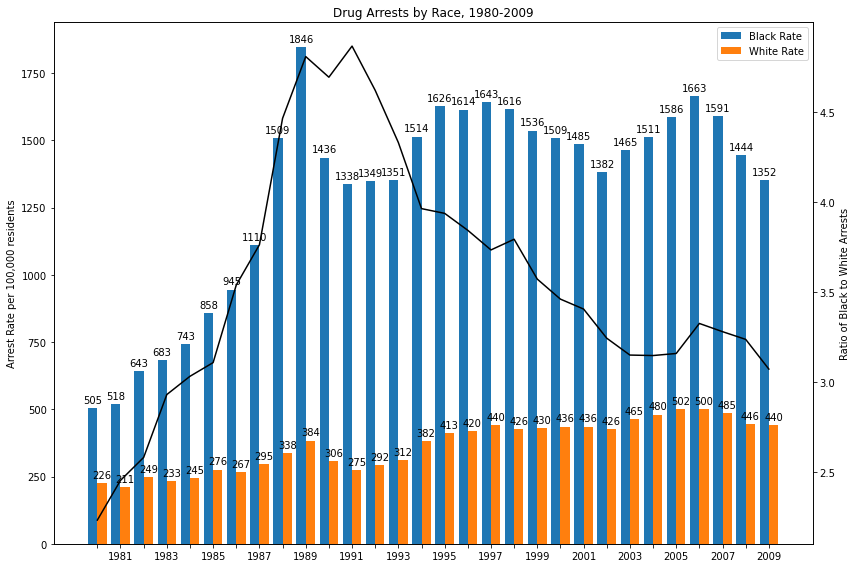

In [90]:
table2 = pd.read_csv(add_data_dir("Police/oxford_race_drugs_report/table2.csv"))

x = np.arange(len(table2))
width = 0.4

fig, ax = plt.subplots(figsize=figsize)
black_rectangle = ax.bar(x - width/2, table2["Black Rate"], width, label="Black Rate")
white_rectangle = ax.bar(x + width/2, table2["White Rate"], width, label="White Rate")

ax.set_ylabel("Arrest Rate per 100,000 residents")
ax.set_title("Drug Arrests by Race, 1980-2009")
ax.set_xticks(x)
ax.set_xticklabels([i if i % 2 == 1 else "" for i in x+1980])
ax.legend(fancybox=True, framealpha=0.05)

padding=3
ax.bar_label(black_rectangle, padding=padding)
ax.bar_label(white_rectangle, padding=padding)

ax2 = table2["True Rate"].plot(secondary_y=True, c="#000000")
ax2.set_ylabel("Ratio of Black to White Arrests")

fig.tight_layout()

plt.savefig(f"{output_folder}/prison/table2.png", transparent=True)
plt.show()
del ax2

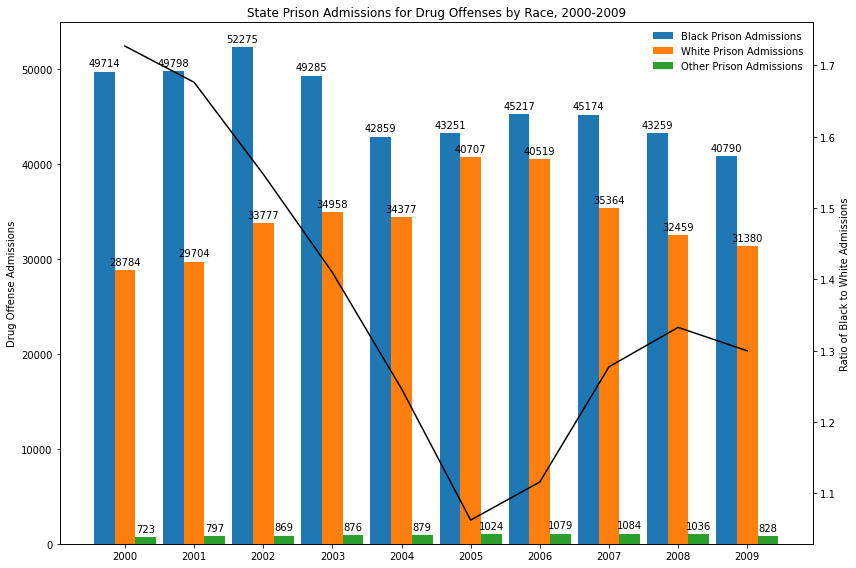

In [91]:
table3 = pd.read_csv(add_data_dir("Police/oxford_race_drugs_report\\table3.csv"))
table_2_3 = table2[table2["Year"].isin(np.arange(2000, 2010))].merge(table3, on="Year")

table_2_3 = table_2_3.set_index("Year")
table_2_3["Ratio of Black to White Admission"] = table_2_3.apply(lambda row: row["Black"]/row["White"], axis=1)

fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
x = np.arange(len(table_2_3))
width = .3

black_rectangle = ax1.bar(x - width, table_2_3["Black"], width, label="Black Prison Admissions")
white_rectangle = ax1.bar(x, table_2_3["White"], width, label="White Prison Admissions")
other_rectangle = ax1.bar(x + width, table_2_3["Other*"], width, label="Other Prison Admissions")

ax1.set_ylabel("Drug Offense Admissions")
ax1.set_title("State Prison Admissions for Drug Offenses by Race, 2000-2009")
ax1.set_xticks(x)
ax1.set_xticklabels(table_2_3.index)
ax1.legend(fancybox=True, framealpha=0.05)

padding=3
ax1.bar_label(black_rectangle, padding=padding)
ax1.bar_label(white_rectangle, padding=padding)
ax1.bar_label(other_rectangle, padding=padding)

ax2.plot(x, table_2_3["Ratio of Black to White Admission"], color='#000')
ax2.set_ylabel("Ratio of Black to White Admissions")
fig.tight_layout()

plt.savefig(f"{output_folder}/prison/table3.png", transparent=True)
plt.show()

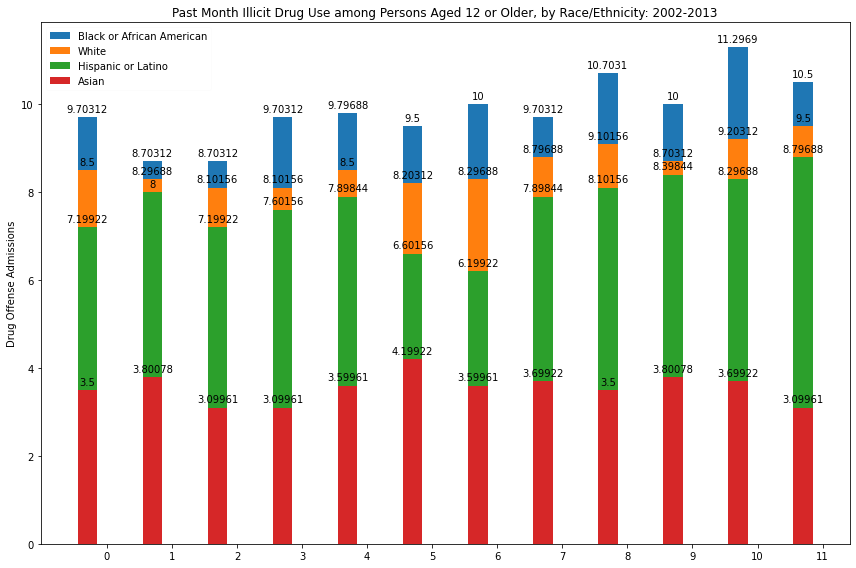

In [92]:
stacked_inmates_grapher(Inmates(add_data_dir("Prison/racialdruguse.csv")), "Year", title="Past Month Illicit Drug Use among Persons Aged 12 or Older, by Race/Ethnicity: 2002-2013", save="stacked.png")

<Figure size 864x576 with 0 Axes>

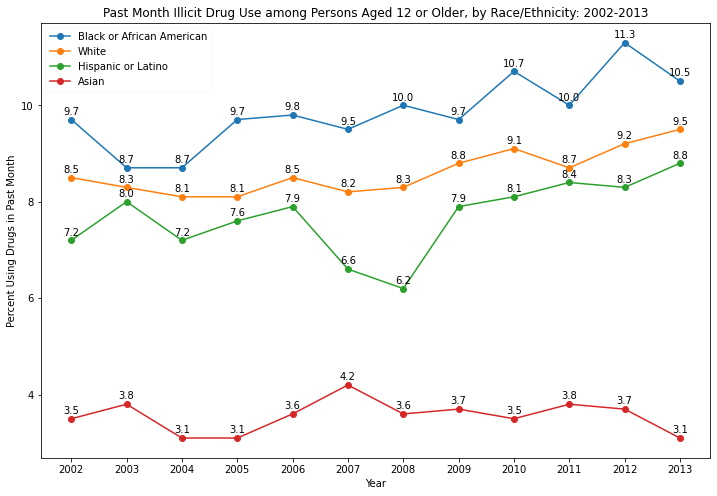

In [93]:
inmates_grapher(Inmates(add_data_dir("Prison/racialdruguse.csv"), index=False), x="Year", ylabel="Percent Using Drugs in Past Month", title="Past Month Illicit Drug Use among Persons Aged 12 or Older, by Race/Ethnicity: 2002-2013", save="illicit_drug_use.png")

In [94]:
#inmates_grapher(Inmates(add_data_dir("Prison/jail_inmates_2018/ji18at01.csv"), index=False), df="race", ylabel="Percent Using Drugs in Past Month", title="Past Month Illicit Drug Use among Persons Aged 12 or Older, by Race/Ethnicity: 2002-2013", save="prison_estimated_population.png")

In [95]:
drug_sales_by_race = pd.read_csv(add_data_dir("Police/oxford_race_drugs_report/sales.csv")).set_index("Drug Type")
drug_sales_by_race.head()

,White,Black,Native American,Asian,Total
Drug Type,,,,,
Cocaine/Heroin,34787,45635,346,351,81119
Marijuana,50196,30210,582,838,81826
Other,60015,11369,480,703,72567
Total,144998,87214,1408,1892,235512


In [96]:
drug_possession_by_race = pd.read_csv(add_data_dir("Police/oxford_race_drugs_report/possession.csv")).set_index("Drug Type")
drug_possession_by_race.head()

,White,Black,Native American,Asian,Total
Drug Type,,,,,
Cocaine/Heroin,132466,74107,772,1410,208755
Marijuana,392127,187577,4806,4906,589416
Other,207809,41004,2009,2718,253540
Total,732402,302688,7587,9034,1051711


In [97]:
my_demographic = print_sql_data(police_brutality_cursor, "SELECT * FROM police_brutality.mapping_police_violence WHERE city = 'Chicago' AND state = 'IL' AND race = 'Black' AND age < 20 AND age > 15")

,Victim's name,Victim's age,Victim's gender,Victim's race,Date of Incident,Street Address of Incident,City,State,Zipcode,County,Agency Responsible for Death,ORI Agency Identifier,Cause of death,Criminal Charges,Symptoms of mental illness,Armed/Unarmed Status,Fleeing,Body Camera,Off-Duty Killing,Call for Service
712,Travon Chadwell,18,Male,Black,2021-03-25,2400 West 46th St.,Chicago,IL,60632,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Allegedly Armed,Car,Unknown,False,True
2755,Curtis Stagger,21,Male,Black,2019-05-28,8100 S Chappel Ave,Chicago,IL,60617,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Allegedly Armed,Not Fleeing,False,False,False
3031,Michael Elam,20,Male,Black,2019-02-16,2100 S Keeler Ave,Chicago,IL,60623,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Allegedly Armed,Car,False,False,False
3308,Sarge Junior,16,Male,Black,2018-11-22,5800 N Talman Ave,Chicago,IL,60659,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Allegedly Armed,Unknown,Unknown,True,False
4953,Corsean Lewis,17,Male,Black,2017-06-02,5800 S Wabash Ave,Chicago,IL,60637,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Allegedly Armed,Not Fleeing,False,False,Unavailable
4997,Rashad S. Wells Jr.,17,Male,Black,2017-05-17,132 W 69th St,Chicago,IL,60621,Cook,Cook County Sheriff's Office,IL0160000,Gunshot,No known charges,False,Allegedly Armed,Not Fleeing,Unknown,True,Unavailable
5357,Joshua D. Jones,20,Male,Black,2017-01-20,12300 South Wallace,Chicago,IL,60628,Cook,Robbins Police Department,IL0169700,Gunshot,No known charges,False,Allegedly Armed,Not Fleeing,Unknown,True,Unavailable
5527,Kajuan Raye,19,Male,Black,2016-11-23,6500 S. Marshfield Ave,Chicago,IL,60636,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Unclear,Foot,False,False,Unavailable
5867,Paul O'Neal,18,Male,Black,2016-07-28,7300 S Merrill Ave,Chicago,IL,60649,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Vehicle,Car,True,False,Unavailable
6180,Pierre Loury,16,Male,Black,2016-04-11,3400 West Grenshaw Street,Chicago,IL,60624,Cook,Chicago Police Department,ILCPD0000,Gunshot,No known charges,False,Allegedly Armed,Foot,False,False,Unavailable


In [98]:
len(my_demographic)

23

In [99]:
police_brutality_cursor.execute("SELECT COUNT(id) FROM police_brutality.mapping_police_violence")
police_brutality_cursor.fetchone()[0]

9727